# Word Embeddings + various classification algorithms

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import gensim
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer

import time
import csv
from tqdm import tqdm
from bs4 import BeautifulSoup
import re, string
import nltk
from nltk.corpus import stopwords
import pickle
from tabulate import tabulate

import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-06-08 01:19:25.678784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('../../data/liar_dataset/train.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])
test = pd.read_csv('../../data/liar_dataset/test.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])
valid = pd.read_csv('../../data/liar_dataset/valid.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])

train = pd.concat([train, valid])

In [3]:
train['label'].value_counts()

half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: label, dtype: int64

In [4]:
convert_text_labels = lambda x: 0 if x in ['true', 'mostly-true', 'half-true'] else 1

In [5]:
train['label'] = train['label'].apply(convert_text_labels)
test['label'] = test['label'].apply(convert_text_labels)

In [6]:
train['label'].value_counts()

0    6420
1    5104
Name: label, dtype: int64

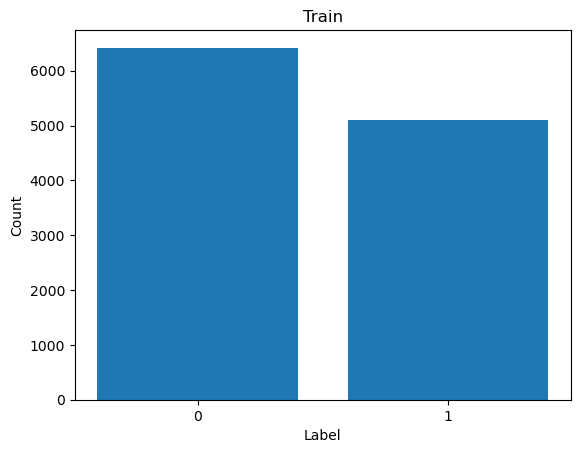

In [7]:
plt.bar(train['label'].value_counts().index, train['label'].value_counts().values)

plt.xticks(train['label'].value_counts().index)

plt.title('Train')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [8]:
test['label'].value_counts()

0    714
1    553
Name: label, dtype: int64

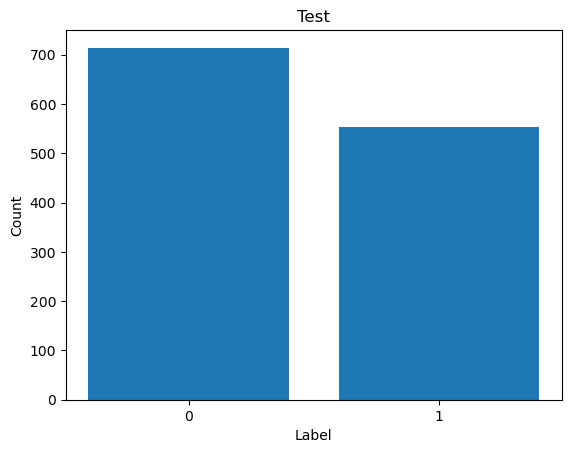

In [9]:
plt.bar(test['label'].value_counts().index, test['label'].value_counts().values)

plt.xticks(test['label'].value_counts().index)

plt.title('Test')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [12]:
# # OLD data
# fake = pd.read_csv('../../data/Fake.csv')
# true = pd.read_csv('../../data/True.csv')
#
# fake["label"] = 0
# true["label"] = 1
#
# df = pd.concat([fake, true], ignore_index = True)
#
# df['text'] = df['title'] + " " + df['text']
# df.drop(columns=['title', 'date', 'subject'], inplace = True)

In [22]:
%%time
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    text = re.sub('\[[^]]*\]', '', text)
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
    
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

train['text']=train['text'].apply(denoise_text)
test['text']=test['text'].apply(denoise_text)

train.to_csv("../../data/train.csv", index=False)
test.to_csv("../../data/test.csv", index=False)


X_train = train['text'].tolist()
y_train = train['label'].tolist()
with open("../../data/X_train", "wb") as fp:
    pickle.dump(X_train, fp)
with open("../../data/y_train", "wb") as fp:
    pickle.dump(y_train, fp)

X_test = test['text'].tolist()
y_test = test['label'].tolist()
with open("../../data/X_test", "wb") as fp:
    pickle.dump(X_test, fp)
with open("../../data/y_test", "wb") as fp:
    pickle.dump(y_test, fp)


train_small = train.sample(frac=1).reset_index(drop=True)[:1000]
train_small.to_csv("../../data/train_small.csv", index=False)

X_train_small = train_small['text'].tolist()
y_train_small = train_small['label'].tolist()
with open("../../data/small/X_train", "wb") as fp:
    pickle.dump(X_train_small, fp)
with open("../../data/small/y_train", "wb") as fp:
    pickle.dump(y_train_small, fp)
with open("../../data/small/X_test", "wb") as fp:
    pickle.dump(X_test, fp)
with open("../../data/small/y_test", "wb") as fp:
    pickle.dump(y_test, fp)

[nltk_data] Downloading package stopwords to /home/szymon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/szymon/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


CPU times: user 917 ms, sys: 19.6 ms, total: 937 ms
Wall time: 1.1 s


There are 409984 words in train set
There are 44259 words in test set
[('Says', 1226), ('Obama', 386), ('health', 332), ('percent', 316), ('tax', 267), ('would', 264), ('people', 261), ('state', 257), ('care', 249), ('President', 244)]
[('Says', 136), ('percent', 40), ('Obama', 40), ('tax', 39), ('health', 33), ('President', 31), ('Barack', 28), ('care', 27), ('state', 24), ('would', 24)]


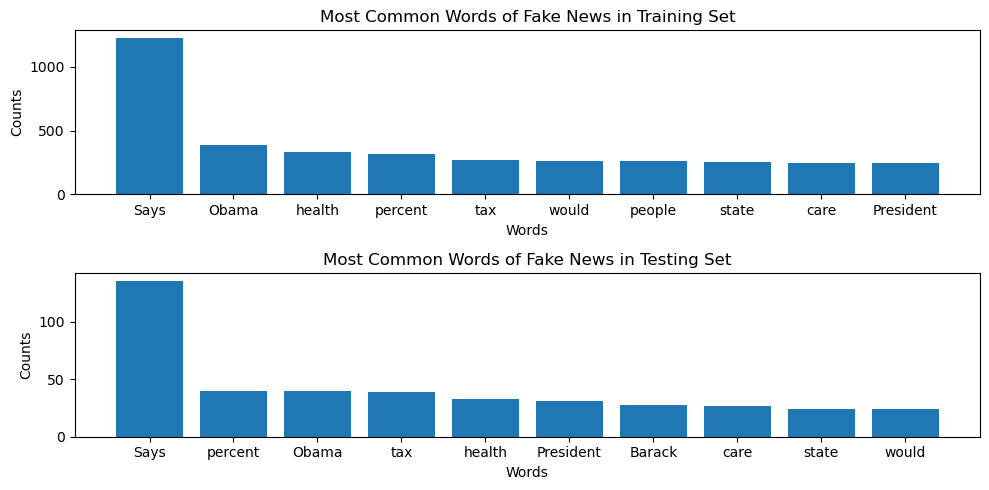

In [62]:
from collections import Counter

text_to_cloud_train_fake = " ".join(news for news in train.loc[train["label"]==1].text)
print ("There are {} words in train set".format(len(text_to_cloud_train_fake)))

text_to_cloud_test_fake = " ".join(news for news in test.loc[test["label"]==1].text)
print ("There are {} words in test set".format(len(text_to_cloud_test_fake)))

Counter_train = Counter(text_to_cloud_train_fake.split())
most_occur_train_fake = Counter_train.most_common(10)
print(most_occur_train_fake)

Counter_test = Counter(text_to_cloud_test_fake.split())
most_occur_test_fake = Counter_test.most_common(10)
print(most_occur_test_fake)

# Data for training set
labels_train = [word for word, _ in most_occur_train_fake]
counts_train = [count for _, count in most_occur_train_fake]

# Data for testing set
labels_test = [word for word, _ in most_occur_test_fake]
counts_test = [count for _, count in most_occur_test_fake]

# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.bar(labels_train, counts_train)
plt.title('Most Common Words of Fake News in Training Set')
plt.xlabel('Words')
plt.ylabel('Counts')

plt.subplot(2, 1, 2)
plt.bar(labels_test, counts_test)
plt.title('Most Common Words of Fake News in Testing Set')
plt.xlabel('Words')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

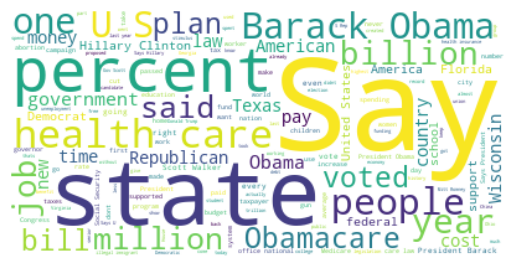

In [57]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(background_color="white").generate(text_to_cloud_train_fake)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

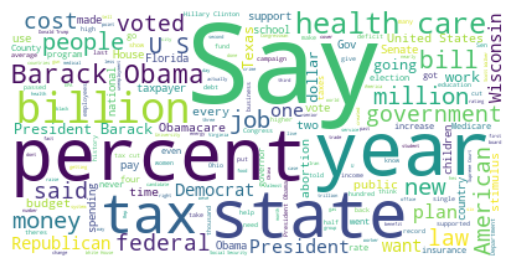

In [58]:
wordcloud = WordCloud(background_color="white").generate(text_to_cloud_test_fake)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 409984 words in train set
There are 44259 words in test set
[('Says', 1296), ('percent', 761), ('state', 410), ('tax', 371), ('million', 330), ('people', 326), ('would', 325), ('Obama', 308), ('health', 298), ('one', 253)]
[('Says', 136), ('percent', 40), ('Obama', 40), ('tax', 39), ('health', 33), ('President', 31), ('Barack', 28), ('care', 27), ('state', 24), ('would', 24)]


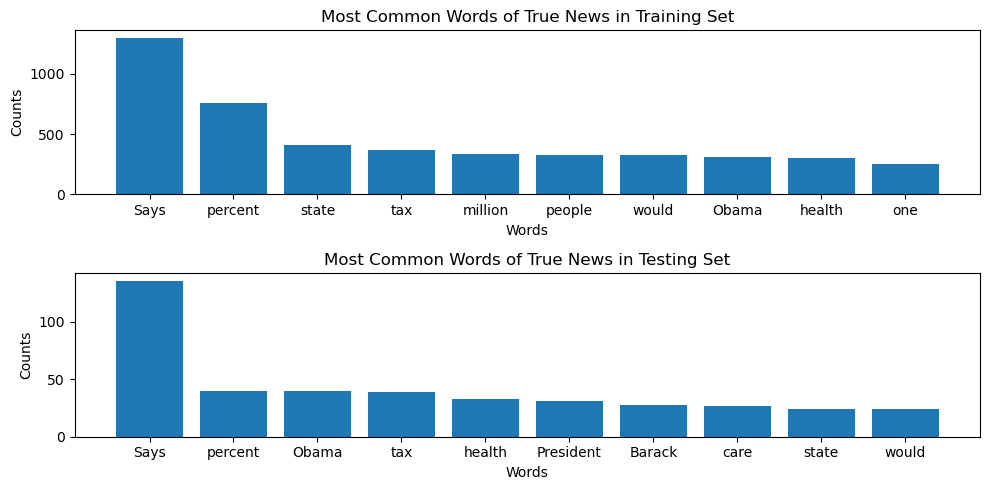

In [59]:
text_to_cloud_train_true = " ".join(news for news in train.loc[train["label"]==0].text)
print ("There are {} words in train set".format(len(text_to_cloud_train_fake)))

text_to_cloud_test_true = " ".join(news for news in test.loc[test["label"]==0].text)
print ("There are {} words in test set".format(len(text_to_cloud_test_fake)))

Counter_train = Counter(text_to_cloud_train_true.split())
most_occur_train_true = Counter_train.most_common(10)
print(most_occur_train_true)

Counter_test = Counter(text_to_cloud_test_fake.split())
most_occur_test_true = Counter_test.most_common(10)
print(most_occur_test_true)

# Data for training set
labels_train = [word for word, _ in most_occur_train_true]
counts_train = [count for _, count in most_occur_train_true]

# Data for testing set
labels_test = [word for word, _ in most_occur_test_true]
counts_test = [count for _, count in most_occur_test_true]

# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.bar(labels_train, counts_train)
plt.title('Most Common Words of True News in Training Set')
plt.xlabel('Words')
plt.ylabel('Counts')

plt.subplot(2, 1, 2)
plt.bar(labels_test, counts_test)
plt.title('Most Common Words of True News in Testing Set')
plt.xlabel('Words')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

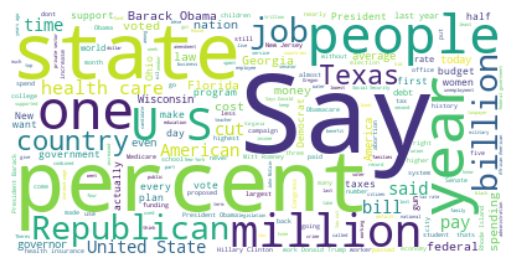

In [60]:
wordcloud = WordCloud(background_color="white").generate(text_to_cloud_train_true)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

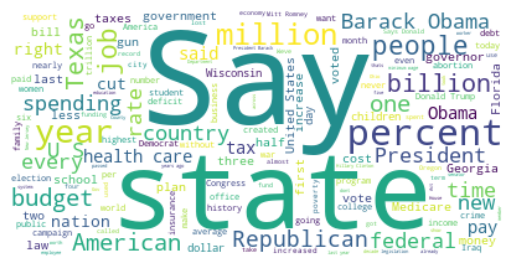

In [61]:
wordcloud = WordCloud(background_color="white").generate(text_to_cloud_test_true)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
train['text'].str.len().describe()

count    11524.000000
mean        80.815776
std         46.508955
min          8.000000
25%         56.000000
50%         75.000000
75%        100.000000
max       2711.000000
Name: text, dtype: float64

In [64]:
test['text'].str.len().describe()

count    1267.000000
mean       83.346488
std        83.251465
min         9.000000
25%        57.000000
50%        75.000000
75%        99.000000
max      2560.000000
Name: text, dtype: float64

---

Reduce dataset for testing purposes

In [14]:
# df_original = df.copy()
# df = df.sample(frac=1).reset_index(drop=True)[:1000]

---

# Embedding

In [15]:
redo_embedding = False # recalculate embeddings
fast = False # True if use reduced dataset (1000 obs) vs. False if full dataset (40000 obs)

In [16]:
%%time
# Load data

# OLD approach ------------------------
# if fast:
#     df_original = df.copy()
#     df = df.sample(frac=1).reset_index(drop=True)[:1000]
#
# if redo_embedding:
#     X = df['text'].tolist()
#     y = df['label'].tolist()
#
#     with open("X", "wb") as fp:
#       pickle.dump(X, fp)
#     with open("y", "wb") as fp:
#       pickle.dump(y, fp)
# elif fast:
#     with open("../../data/small/X", "rb") as fp:
#       X = pickle.load(fp)
#     with open("../../data/small/y", "rb") as fp:
#       y = pickle.load(fp)
# else:
#     with open("../../data/X", "rb") as fp:
#       X = pickle.load(fp)
#     with open("../../data/y", "rb") as fp:
#       y = pickle.load(fp)
#
# if redo_embedding:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#     with open("X_train", "wb") as fp:
#       pickle.dump(X_train, fp)
#     with open("X_test", "wb") as fp:
#       pickle.dump(X_test, fp)
#     with open("y_train", "wb") as fp:
#       pickle.dump(y_train, fp)
#     with open("y_test", "wb") as fp:
#       pickle.dump(y_test, fp)
# elif fast:
#     with open("../../data/small/X_train", "rb") as fp:
#       X_train = pickle.load(fp)
#     with open("../../data/small/X_test", "rb") as fp:
#       X_test = pickle.load(fp)
#     with open("../../data/small/y_train", "rb") as fp:
#       y_train = pickle.load(fp)
#     with open("../../data/small/y_test", "rb") as fp:
#       y_test = pickle.load(fp)
# else:
#     with open("../../data/X_train", "rb") as fp:
#       X_train = pickle.load(fp)
#     with open("../../data/X_test", "rb") as fp:
#       X_test = pickle.load(fp)
#     with open("../../data/y_train", "rb") as fp:
#       y_train = pickle.load(fp)
#     with open("../../data/y_test", "rb") as fp:
#       y_test = pickle.load(fp)


# NEW approach ------------------------
if fast:
    with open("../../data/small/X_train", "rb") as fp:
      X_train = pickle.load(fp)
    with open("../../data/small/X_test", "rb") as fp:
      X_test = pickle.load(fp)
    with open("../../data/small/y_train", "rb") as fp:
      y_train = pickle.load(fp)
    with open("../../data/small/y_test", "rb") as fp:
      y_test = pickle.load(fp)
else:
    with open("../../data/X_train", "rb") as fp:
      X_train = pickle.load(fp)
    with open("../../data/X_test", "rb") as fp:
      X_test = pickle.load(fp)
    with open("../../data/y_train", "rb") as fp:
      y_train = pickle.load(fp)
    with open("../../data/y_test", "rb") as fp:
      y_test = pickle.load(fp)

CPU times: total: 31.2 ms
Wall time: 18.9 ms


## BERT Embedding

In [17]:
if redo_embedding:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    bert = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert.to(device)

    def _get_bert_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
        input_ids = np.array(input_ids)
        input_ids = np.expand_dims(input_ids, axis=0)
        input_ids = torch.tensor(input_ids).to(device)

        with torch.no_grad():
            outputs = bert(input_ids)
            last_hidden_state = outputs.last_hidden_state
            last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

        return last_hidden_state

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_bert_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_bert = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_bert_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_bert = np.squeeze(X_test_embeddings, axis=1)
    
    if fast:
        pd.DataFrame(X_train_embeddings_bert).to_csv("../../data/small/embeddings/X_train_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_bert).to_csv("../../data/small/embeddings/X_test_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_bert).to_csv("../../data/embeddings/X_train_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_bert).to_csv("../../data/embeddings/X_test_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    
elif fast:
    X_train_embeddings_bert = pd.read_csv('../../data/small/embeddings/X_train_embeddings_bert.csv', sep=',', header=None).values
    X_test_embeddings_bert = pd.read_csv('../../data/small/embeddings/X_test_embeddings_bert.csv', sep=',', header=None).values
else:
    X_train_embeddings_bert = pd.read_csv('../../data/embeddings/X_train_embeddings_bert.csv', sep=',', header=None).values
    X_test_embeddings_bert = pd.read_csv('../../data/embeddings/X_test_embeddings_bert.csv', sep=',', header=None).values

## GloVe Embedding

In [18]:
if redo_embedding:

    def load_glove_embeddings(filename):
        embeddings_index = {}
        with open(filename) as f:
            for line in tqdm(f):
                values = line.split()
                word = values[0]
                if len(values[1:]) == 300:
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
        return embeddings_index

    glove_embeddings = load_glove_embeddings('../../glove/glove.840B.300d.txt')

    def text_to_glove_embeddings(text, embeddings_index, embedding_dim):
        embeddings = []
        for sentence in text:
            sentence_embeddings = []
            for word in sentence.split():
                if word in embeddings_index:
                    sentence_embeddings.append(embeddings_index[word])
            if len(sentence_embeddings) > 0:
                embeddings.append(np.mean(sentence_embeddings, axis=0))
            else:
                embeddings.append(np.zeros(embedding_dim))
        return np.array(embeddings)

    X_train_embeddings_glove = text_to_glove_embeddings(X_train, glove_embeddings, embedding_dim=300)
    X_test_embeddings_glove = text_to_glove_embeddings(X_test, glove_embeddings, embedding_dim=300)
    
    if fast:
        pd.DataFrame(X_train_embeddings_glove).to_csv("../../data/small/embeddings/X_train_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_glove).to_csv("../../data/small/embeddings/X_test_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_glove).to_csv("../../data/embeddings/X_train_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_glove).to_csv("../../data/embeddings/X_test_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_glove = pd.read_csv('../../data/small/embeddings/X_train_embeddings_glove.csv', sep=',', header=None).values
    X_test_embeddings_glove = pd.read_csv('../../data/small/embeddings/X_test_embeddings_glove.csv', sep=',', header=None).values

else:
    X_train_embeddings_glove = pd.read_csv('../../data/embeddings/X_train_embeddings_glove.csv', sep=',', header=None).values
    X_test_embeddings_glove = pd.read_csv('../../data/embeddings/X_test_embeddings_glove.csv', sep=',', header=None).values

## Word2Vec

In [19]:
if redo_embedding:
    model = gensim.models.KeyedVectors.load_word2vec_format('../../word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

def get_word2vec_embeddings(text):
    embeddings = []
    for sentence in tqdm(text):
        tokens = sentence.split()
        doc_vecs = [model[token] for token in tokens if token in model.key_to_index]
        if len(doc_vecs) > 0:
            doc_vec = np.mean(doc_vecs, axis=0)
            embeddings.append(doc_vec)
        else:
            embeddings.append([0] * 300) # if vocabulary does not exist in Word2Vec append a vector of zeros
    return np.array(embeddings)


if redo_embedding:
    # noinspection PyUnboundLocalVariable
    X_train_embeddings_word2vec = get_word2vec_embeddings(X_train)
    X_test_embeddings_word2vec = get_word2vec_embeddings(X_test)

    if fast:
        pd.DataFrame(X_train_embeddings_word2vec).to_csv("../../data/small/embeddings/X_train_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_word2vec).to_csv("../../data/small/embeddings/X_test_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_word2vec).to_csv("../../data/embeddings/X_train_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_word2vec).to_csv("../../data/embeddings/X_test_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_word2vec = pd.read_csv('../../data/small/embeddings/X_train_embeddings_word2vec.csv', sep=',', header=None).values
    X_test_embeddings_word2vec = pd.read_csv('../../data/small/embeddings/X_test_embeddings_word2vec.csv', sep=',', header=None).values

else:
    X_train_embeddings_word2vec = pd.read_csv('../../data/embeddings/X_train_embeddings_word2vec.csv', sep=',', header=None).values
    X_test_embeddings_word2vec = pd.read_csv('../../data/embeddings/X_test_embeddings_word2vec.csv', sep=',', header=None).values

## GPT2

In [20]:
if redo_embedding:
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gpt2.to(device)

    def _get_gpt2_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=1024)
        input_ids = torch.tensor(input_ids).unsqueeze(0).to(device).long()

        with torch.no_grad():
            embeddings = gpt2.transformer.wte(input_ids)
            mean_embedding = embeddings.mean(dim=1)
        #     outputs = bert(input_ids)
        #     last_hidden_state = outputs.last_hidden_state
        #     last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

            #vector = gpt2.transformer.wte.weight[input_ids,:]
        mean_embedding = mean_embedding.cpu().numpy()
        return mean_embedding

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_gpt2_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_gpt2 = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_gpt2_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_gpt2 = np.squeeze(X_test_embeddings, axis=1)

    if fast:
        pd.DataFrame(X_train_embeddings_gpt2).to_csv("../../data/small/embeddings/X_train_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_gpt2).to_csv("../../data/small/embeddings/X_test_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_gpt2).to_csv("../../data/embeddings/X_train_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_gpt2).to_csv("../../data/embeddings/X_test_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_gpt2 = pd.read_csv('../../data/small/embeddings/X_train_embeddings_gpt2.csv', sep=',', header=None).values
    X_test_embeddings_gpt2 = pd.read_csv('../../data/small/embeddings/X_test_embeddings_gpt2.csv', sep=',', header=None).values
else:
    X_train_embeddings_gpt2 = pd.read_csv('../../data/embeddings/X_train_embeddings_gpt2.csv', sep=',', header=None).values
    X_test_embeddings_gpt2 = pd.read_csv('../../data/embeddings/X_test_embeddings_gpt2.csv', sep=',', header=None).values

## RoBERTa

In [21]:
if redo_embedding:
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    roberta = AutoModel.from_pretrained("roberta-base", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    roberta.to(device)

    def _get_roberta_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
        input_ids = np.array(input_ids)
        input_ids = np.expand_dims(input_ids, axis=0)
        input_ids = torch.tensor(input_ids).to(device)

        with torch.no_grad():
            outputs = roberta(input_ids)
            last_hidden_state = outputs.last_hidden_state
            last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

        return last_hidden_state

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_roberta_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_roberta = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_roberta_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_roberta = np.squeeze(X_test_embeddings, axis=1)

    if fast:
        pd.DataFrame(X_train_embeddings_roberta).to_csv("../../data/small/embeddings/X_train_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_roberta).to_csv("../../data/small/embeddings/X_test_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_roberta).to_csv("../../data/embeddings/X_train_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_roberta).to_csv("../../data/embeddings/X_test_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_roberta = pd.read_csv('../../data/small/embeddings/X_train_embeddings_roberta.csv', sep=',', header=None).values
    X_test_embeddings_roberta = pd.read_csv('../../data/small/embeddings/X_test_embeddings_roberta.csv', sep=',', header=None).values
else:
    X_train_embeddings_roberta = pd.read_csv('../../data/embeddings/X_train_embeddings_roberta.csv', sep=',', header=None).values
    X_test_embeddings_roberta = pd.read_csv('../../data/embeddings/X_test_embeddings_roberta.csv', sep=',', header=None).values

# Classification

## Wrappers

### KNN

In [22]:
class KNNClassifier:
    def __init__(self, n_neighbors=2, weights='uniform', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.model = None

    def fit(self, X_train, y_train):
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, metric=self.metric)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)
        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = KNeighborsClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.n_neighbors = random_search.best_params_['n_neighbors']
        self.weights = random_search.best_params_['weights']
        self.metric = random_search.best_params_['metric']

        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, metric=self.metric)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### XGBoost

In [23]:
class XGBoostClassifier:
    def __init__(self, learning_rate=0.1, max_depth=5, min_child_weight=1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='req:squarederror'):
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.n_estimators = n_estimators
        self.objective = objective
        self.model = None

    def fit(self, X_train, y_train):
        self.model = xgb.XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth, min_child_weight=self.min_child_weight, subsample=self.subsample, colsample_bytree=self.colsample_bytree, n_estimators=self.n_estimators, objective=self.objective)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = xgb.XGBClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.learning_rate = random_search.best_params_['learning_rate']
        self.max_depth = random_search.best_params_['max_depth']
        self.min_child_weight = random_search.best_params_['min_child_weight']
        self.subsample = random_search.best_params_['subsample']
        self.colsample_bytree = random_search.best_params_['colsample_bytree']
        self.n_estimators = random_search.best_params_['n_estimators']
        self.objective = random_search.best_params_['objective']

        self.model = xgb.XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth, min_child_weight=self.min_child_weight, subsample=self.subsample, colsample_bytree=self.colsample_bytree, n_estimators=self.n_estimators, objective=self.objective)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Random Forest

In [24]:
class RFClassifier:
    def __init__(self, n_estimators=100, max_features='sqrt', max_depth='none', bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.model = None

    def fit(self, X_train, y_train):
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features, max_depth=self.max_depth, bootstrap=self.bootstrap, verbose=True)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = RandomForestClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.n_estimators = random_search.best_params_['n_estimators']
        self.max_features = random_search.best_params_['max_features']
        self.max_depth = random_search.best_params_['max_depth']
        self.bootstrap = random_search.best_params_['bootstrap']

        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features, max_depth=self.max_depth, bootstrap=self.bootstrap)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### SVC

In [25]:
class SVClassifier:
    def __init__(self, C = 1, kernel='linear', gamma = 0.2):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.model = None

    def fit(self, X_train, y_train):
        self.model = svm.SVC(C=self.C, kernel=self.kernel, gamma=self.gamma, verbose=True)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = svm.SVC()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.C = random_search.best_params_['C']
        self.kernel = random_search.best_params_['kernel']
        self.gamma = random_search.best_params_['gamma']

        self.model = svm.SVC(C=self.C, kernel=self.kernel, gamma=self.gamma)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Logistic Regression

In [26]:
class LRClassifier:
    def __init__(self, penalty = 'l2', solver = 'libinear', C = 0.5):
        self.penalty = penalty
        self.solver = solver
        self.C = C
        self.model = None

    def fit(self, X_train, y_train):
        self.model = LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = LogisticRegression()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.penalty = random_search.best_params_['penalty']
        self.solver = random_search.best_params_['solver']
        self.C = random_search.best_params_['C']

        self.model = LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Neural Network

In [27]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)
        return output

class NeuralNetworkClassifier:
    def __init__(self, input_dim, hidden_dim, dropout, output_dim=2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.model = None

    def fit(self, X_train, y_train, X_val, y_val, patience, num_epochs=10, lr=0.001):
        self.model = None

        self.model = FakeNewsClassifier(self.input_dim, self.hidden_dim, self.output_dim, self.dropout)
        self.model = self.model.float()

        class_counts = np.bincount(y_train)
        num_classes = len(class_counts)
        class_weights = torch.tensor(class_counts.sum() / (num_classes * class_counts), dtype=torch.float)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        best_loss = float('inf')
        early_stop_counter = 0

        train_losses = []
        val_losses = []
        f1_scores = []

        for epoch in range(num_epochs):
            train_loss = 0.0

            self.model.train()

            for embedding, label in zip(X_train, y_train):
                embedding_tensor = torch.from_numpy(embedding).float().unsqueeze(0)
                label_tensor = torch.tensor([label])
                optimizer.zero_grad()
                outputs = self.model(embedding_tensor)
                loss = criterion(outputs, label_tensor)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(X_train)

            self.model.eval()

            with torch.no_grad():
                val_loss = 0.0

                for embedding, label in zip(X_val, y_val):
                    embedding_tensor = torch.from_numpy(embedding).float().unsqueeze(0)
                    label_tensor = torch.tensor([label])
                    outputs = self.model(embedding_tensor)
                    loss = criterion(outputs, label_tensor)
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(X_val)

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)

                y_pred = self.predict(X_val)
                f1 = f1_score(y_val, y_pred)
                f1_scores.append(f1)

                print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Score: {f1:.4f} | Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred):.4f} | AUC: {roc_auc_score(y_val, y_pred):.4f}")

                if avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print(f"Early stopping triggered. No improvement in {patience} epochs.")
                        break

        plt.figure(figsize=(12, 4))
        epochs = np.arange(1, len(train_losses) + 1)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.plot(epochs, f1_scores, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')  # Adding the y-axis label
        plt.legend()  # Adding the legend
        plt.show()

    def predict(self, X_test):
        if self.model is None:
            raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        test_inputs = torch.from_numpy(X_test).float()
        predictions = self.model(test_inputs)
        predicted_classes = torch.argmax(predictions, dim=1)
        predicted_classes = predicted_classes.numpy()
        return predicted_classes

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)
        f1 = round(f1_score(y_test, y_pred) * 100, 1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred) * 100, 1)
        auc = round(roc_auc_score(y_test, y_pred) * 100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', balanced_accuracy, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

OLD NN Wrapper

In [46]:
# class FakeNewsClassifier(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, output_dim):
#         super(FakeNewsClassifier, self).__init__()
#         self.fc1 = nn.Linear(embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.relu = nn.ReLU()
#
#     def forward(self, x):
#         hidden = self.relu(self.fc1(x))
#         output = self.fc2(hidden)
#         return output
#
# class NeuralNetworkClassifier:
#     def __init__(self, input_dim, hidden_dim, output_dim=2):
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim
#         self.model = None
#
#     def fit(self, X_train, y_train, num_epochs=10, lr=0.001):
#         self.model = FakeNewsClassifier(self.input_dim, self.hidden_dim, self.output_dim)
#         self.model = self.model.double()
#
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(self.model.parameters(), lr=lr)
#
#         for _ in tqdm(range(num_epochs), desc="Epoch"):
#             for embedding, label in zip(X_train, y_train):
#                 embedding_tensor = torch.from_numpy(embedding).double().unsqueeze(0)
#                 label_tensor = torch.tensor([label])
#                 optimizer.zero_grad()
#                 outputs = self.model(embedding_tensor)
#                 loss = criterion(outputs, label_tensor)
#                 loss.backward()
#                 optimizer.step()
#
#     def predict(self, X_test):
#         if self.model is None:
#             raise ValueError("The model has not been trained yet. Please call 'fit' first.")
#         test_inputs = torch.from_numpy(X_test).double()
#         predictions = self.model(test_inputs)
#         predicted_classes = torch.argmax(predictions, dim=1)
#         predicted_classes = predicted_classes.numpy()
#         return predicted_classes
#
#     def evaluate(self, X_test, y_test):
#         if self.model is None:
#             raise ValueError("The model has not been trained yet. Please call 'fit' first.")
#         y_pred = self.predict(X_test)
#
#         cm = confusion_matrix(y_test, y_pred)
#         accuracy = round(accuracy_score(y_test, y_pred)*100, 1)
#         f1 = round(f1_score(y_test, y_pred)*100, 1)
#         balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
#         auc = round(roc_auc_score(y_test, y_pred)*100, 1)
#
#         print('\nConfusion matrix\n', cm, '\n')
#         print('Accuracy:', accuracy, '\n')
#         print('F1 Score:', f1, '\n')
#         print('Balanced accuracy:', f1, '\n')
#         print('AUC Score:', auc, '\n')
#
#         return cm, accuracy, f1, balanced_accuracy, auc

## BERT embeddings

### BERT + KNN

In [77]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_bert_train, accuracy_knn_bert_train, f1_knn_bert_train, balaccuracy_knn_bert_train, rocauc_knn_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_knn_bert_test, accuracy_knn_bert_test, f1_knn_bert_test, balaccuracy_knn_bert_test, rocauc_knn_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.352 total time=   0.3s
[CV 2/5] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.363 total time=   0.3s
[CV 3/5] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.357 total time=   0.3s
[CV 4/5] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.316 total time=   0.3s
[CV 5/5] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.333 total time=   0.3s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.520 total time=   7.7s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.514 total time=   7.6s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.512 total time=   7.8s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.471 total time=   7.5s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.487 total t

In [78]:
cm_knn_bert_train_tosave = repr(cm_knn_bert_train)
accuracy_knn_bert_train_tosave = repr(accuracy_knn_bert_train)
f1_knn_bert_train_tosave = repr(f1_knn_bert_train)
balaccuracy_knn_bert_train_tosave = repr(balaccuracy_knn_bert_train)
rocauc_knn_bert_train_tosave = repr(rocauc_knn_bert_train)

cm_knn_bert_test_tosave = repr(cm_knn_bert_test)
accuracy_knn_bert_test_tosave = repr(accuracy_knn_bert_test)
f1_knn_bert_test_tosave = repr(f1_knn_bert_test)
balaccuracy_knn_bert_test_tosave = repr(balaccuracy_knn_bert_test)
rocauc_knn_bert_test_tosave = repr(rocauc_knn_bert_test)


file = open("results_split/knn_bert_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_knn_bert_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_knn_bert_train_tosave + "\n" +
           "Train F1 = "+f1_knn_bert_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_knn_bert_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_knn_bert_train_tosave + "\n"+
           "Test CM = "+cm_knn_bert_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_knn_bert_test_tosave + "\n"+
           "Test F1 = "+f1_knn_bert_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_knn_bert_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_knn_bert_test_tosave)

file.close()

### BERT + XGBoost

In [79]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_bert_train, accuracy_xgb_bert_train, f1_xgb_bert_train, balaccuracy_xgb_bert_train, rocauc_xgb_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_xgb_bert_test, accuracy_xgb_bert_test, f1_xgb_bert_test, balaccuracy_xgb_bert_test, rocauc_xgb_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.488 total time=  19.1s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.475 total time=  19.1s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.489 total time=  19.5s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.461 total time=  19.5s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.496 total time=  19.3s
[CV 1/5] END colsample_bytree=0.7, lea

In [80]:
cm_xgb_bert_train_tosave = repr(cm_xgb_bert_train)
accuracy_xgb_bert_train_tosave = repr(accuracy_xgb_bert_train)
f1_xgb_bert_train_tosave = repr(f1_xgb_bert_train)
balaccuracy_xgb_bert_train_tosave = repr(balaccuracy_xgb_bert_train)
rocauc_xgb_bert_train_tosave = repr(rocauc_xgb_bert_train)

cm_xgb_bert_test_tosave = repr(cm_xgb_bert_test)
accuracy_xgb_bert_test_tosave = repr(accuracy_xgb_bert_test)
f1_xgb_bert_test_tosave = repr(f1_xgb_bert_test)
balaccuracy_xgb_bert_test_tosave = repr(balaccuracy_xgb_bert_test)
rocauc_xgb_bert_test_tosave = repr(rocauc_xgb_bert_test)


file = open("results_split/xgb_bert_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_xgb_bert_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_xgb_bert_train_tosave + "\n" +
           "Train F1 = "+f1_xgb_bert_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_xgb_bert_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_xgb_bert_train_tosave + "\n"+
           "Test CM = "+cm_xgb_bert_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_xgb_bert_test_tosave + "\n"+
           "Test F1 = "+f1_xgb_bert_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_xgb_bert_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_xgb_bert_test_tosave)

file.close()

### BERT + Random Forest

In [81]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25], 
    'max_features': [5, 10],
    'max_depth': [10, 50, None], 
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_bert_train, accuracy_rf_bert_train, f1_rf_bert_train, balaccuracy_rf_bert_train, rocauc_rf_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_rf_bert_test, accuracy_rf_bert_test, f1_rf_bert_test, balaccuracy_rf_bert_test, rocauc_rf_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.405 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.369 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.384 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.379 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.393 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=25;, score=0.437 total time=   2.2s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=25;, score=0.442 total time=   2.2s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=25;, score=0.461 total time=   2.4s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=10, n_e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[6420    0]
 [   4 5100]] 

Accuracy: 100.0 

F1 Score: 100.0 

Balanced accuracy: 100.0 

AUC Score: 100.0 


----- TEST -----

Confusion matrix
 [[504 210]
 [327 226]] 

Accuracy: 57.6 

F1 Score: 45.7 

Balanced accuracy: 45.7 

AUC Score: 55.7 

_______________________________________________________________________


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [82]:
cm_rf_bert_train_tosave = repr(cm_rf_bert_train)
accuracy_rf_bert_train_tosave = repr(accuracy_rf_bert_train)
f1_rf_bert_train_tosave = repr(f1_rf_bert_train)
balaccuracy_rf_bert_train_tosave = repr(balaccuracy_rf_bert_train)
rocauc_rf_bert_train_tosave = repr(rocauc_rf_bert_train)

cm_rf_bert_test_tosave = repr(cm_rf_bert_test)
accuracy_rf_bert_test_tosave = repr(accuracy_rf_bert_test)
f1_rf_bert_test_tosave = repr(f1_rf_bert_test)
balaccuracy_rf_bert_test_tosave = repr(balaccuracy_rf_bert_test)
rocauc_rf_bert_test_tosave = repr(rocauc_rf_bert_test)


file = open("results_split/rf_bert_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_rf_bert_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_rf_bert_train_tosave + "\n" +
           "Train F1 = "+f1_rf_bert_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_rf_bert_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_rf_bert_train_tosave + "\n"+
           "Test CM = "+cm_rf_bert_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_rf_bert_test_tosave + "\n"+
           "Test F1 = "+f1_rf_bert_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_rf_bert_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_rf_bert_test_tosave)

file.close()

### BERT + SVC

In [ ]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_bert_train, accuracy_svc_bert_train, f1_svc_bert_train, balaccuracy_svc_bert_train, rocauc_svc_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_svc_bert_test, accuracy_svc_bert_test, f1_svc_bert_test, balaccuracy_svc_bert_test, rocauc_svc_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.507 total time= 1.6min
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.510 total time= 1.6min
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.482 total time= 1.5min
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.508 total time= 1.6min
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.522 total time= 1.6min
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.494 total time=  25.7s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.506 total time=  26.0s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.491 total time=  25.7s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.494 total time=  25.8s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.520 total time=  26.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.490 total time=  30.4s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

In [ ]:
cm_svc_bert_train_tosave = repr(cm_svc_bert_train)
accuracy_svc_bert_train_tosave = repr(accuracy_svc_bert_train)
f1_svc_bert_train_tosave = repr(f1_svc_bert_train)
balaccuracy_svc_bert_train_tosave = repr(balaccuracy_svc_bert_train)
rocauc_svc_bert_train_tosave = repr(rocauc_svc_bert_train)

cm_svc_bert_test_tosave = repr(cm_svc_bert_test)
accuracy_svc_bert_test_tosave = repr(accuracy_svc_bert_test)
f1_svc_bert_test_tosave = repr(f1_svc_bert_test)
balaccuracy_svc_bert_test_tosave = repr(balaccuracy_svc_bert_test)
rocauc_svc_bert_test_tosave = repr(rocauc_svc_bert_test)


file = open("results_split/svc_bert_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_svc_bert_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_svc_bert_train_tosave + "\n" +
           "Train F1 = "+f1_svc_bert_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_svc_bert_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_svc_bert_train_tosave + "\n"+
           "Test CM = "+cm_svc_bert_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_svc_bert_test_tosave + "\n"+
           "Test F1 = "+f1_svc_bert_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_svc_bert_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_svc_bert_test_tosave)

file.close()

### BERT + Logistic Regression

In [ ]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_bert_train, accuracy_lr_bert_train, f1_lr_bert_train, balaccuracy_lr_bert_train, rocauc_lr_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_lr_bert_test, accuracy_lr_bert_test, f1_lr_bert_test, balaccuracy_lr_bert_test, rocauc_lr_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

In [ ]:
cm_lr_bert_train_tosave = repr(cm_lr_bert_train)
accuracy_lr_bert_train_tosave = repr(accuracy_lr_bert_train)
f1_lr_bert_train_tosave = repr(f1_lr_bert_train)
balaccuracy_lr_bert_train_tosave = repr(balaccuracy_lr_bert_train)
rocauc_lr_bert_train_tosave = repr(rocauc_lr_bert_train)

cm_lr_bert_test_tosave = repr(cm_lr_bert_test)
accuracy_lr_bert_test_tosave = repr(accuracy_lr_bert_test)
f1_lr_bert_test_tosave = repr(f1_lr_bert_test)
balaccuracy_lr_bert_test_tosave = repr(balaccuracy_lr_bert_test)
rocauc_lr_bert_test_tosave = repr(rocauc_lr_bert_test)


file = open("results_split/lr_bert_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_lr_bert_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_lr_bert_train_tosave + "\n" +
           "Train F1 = "+f1_lr_bert_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_lr_bert_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_lr_bert_train_tosave + "\n"+
           "Test CM = "+cm_lr_bert_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_lr_bert_test_tosave + "\n"+
           "Test F1 = "+f1_lr_bert_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_lr_bert_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_lr_bert_test_tosave)

file.close()

### BERT + Neural Network

In [ ]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_bert.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_bert.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_bert, y_train, X_test_embeddings_bert, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_bert_train, accuracy_nn_bert_train, f1_nn_bert_train, balaccuracy_nn_bert_train, rocauc_nn_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_nn_bert_test, accuracy_nn_bert_test, f1_nn_bert_test, balaccuracy_nn_bert_test, rocauc_nn_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

In [ ]:
cm_nn_bert_train_tosave = repr(cm_nn_bert_train)
accuracy_nn_bert_train_tosave = repr(accuracy_nn_bert_train)
f1_nn_bert_train_tosave = repr(f1_nn_bert_train)
balaccuracy_nn_bert_train_tosave = repr(balaccuracy_nn_bert_train)
rocauc_nn_bert_train_tosave = repr(rocauc_nn_bert_train)

cm_nn_bert_test_tosave = repr(cm_nn_bert_test)
accuracy_nn_bert_test_tosave = repr(accuracy_nn_bert_test)
f1_nn_bert_test_tosave = repr(f1_nn_bert_test)
balaccuracy_nn_bert_test_tosave = repr(balaccuracy_nn_bert_test)
rocauc_nn_bert_test_tosave = repr(rocauc_nn_bert_test)


file = open("results_split/nn_bert_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_nn_bert_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_nn_bert_train_tosave + "\n" +
           "Train F1 = "+f1_nn_bert_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_nn_bert_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_nn_bert_train_tosave + "\n"+
           "Test CM = "+cm_nn_bert_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_nn_bert_test_tosave + "\n"+
           "Test F1 = "+f1_nn_bert_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_nn_bert_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_nn_bert_test_tosave)

file.close()

## GloVe embeddings

### GloVe + KNN

In [65]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_glove_train, accuracy_knn_glove_train, f1_knn_glove_train, balaccuracy_knn_glove_train, rocauc_knn_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_knn_glove_test, accuracy_knn_glove_test, f1_knn_glove_test, balaccuracy_knn_glove_test, rocauc_knn_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.460 total time=   2.8s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.466 total time=   2.8s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.488 total time=   2.8s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.481 total time=   2.8s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.513 total time=   2.7s
[CV 1/5] END metric=minkowski, n_neighbors=6, weights=distance;, score=0.471 total time=   0.1s
[CV 2/5] END metric=minkowski, n_neighbors=6, weights=distance;, score=0.490 total time=   0.1s
[CV 3/5] END metric=minkowski, n_neighbors=6, weights=distance;, score=0.508 total time=   0.1s
[CV 4/5] END metric=minkowski, n_neighbors=6, weights=distance;, score=0.482 total time=   0.1s
[CV 5/5] END metric=minkowski, n_neighbors=6, weights=distance;, score=0.5

In [66]:
cm_knn_glove_train_tosave = repr(cm_knn_glove_train)
accuracy_knn_glove_train_tosave = repr(accuracy_knn_glove_train)
f1_knn_glove_train_tosave = repr(f1_knn_glove_train)
balaccuracy_knn_glove_train_tosave = repr(balaccuracy_knn_glove_train)
rocauc_knn_glove_train_tosave = repr(rocauc_knn_glove_train)

cm_knn_glove_test_tosave = repr(cm_knn_glove_test)
accuracy_knn_glove_test_tosave = repr(accuracy_knn_glove_test)
f1_knn_glove_test_tosave = repr(f1_knn_glove_test)
balaccuracy_knn_glove_test_tosave = repr(balaccuracy_knn_glove_test)
rocauc_knn_glove_test_tosave = repr(rocauc_knn_glove_test)


file = open("results_split/knn_glove_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_knn_glove_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_knn_glove_train_tosave + "\n" +
           "Train F1 = "+f1_knn_glove_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_knn_glove_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_knn_glove_train_tosave + "\n"+
           "Test CM = "+cm_knn_glove_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_knn_glove_test_tosave + "\n"+
           "Test F1 = "+f1_knn_glove_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_knn_glove_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_knn_glove_test_tosave)

file.close()

### GloVe + XGBoost

In [67]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_glove_train, accuracy_xgb_glove_train, f1_xgb_glove_train, balaccuracy_xgb_glove_train, rocauc_xgb_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_xgb_glove_test, accuracy_xgb_glove_test, f1_xgb_glove_test, balaccuracy_xgb_glove_test, rocauc_xgb_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.501 total time=  17.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.480 total time=  18.2s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.480 total time=  17.3s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.500 total time=  17.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.499 total time=  18.1s
[CV 1/5] END colsample_bytree=0.5, lea

In [68]:
cm_xgb_glove_train_tosave = repr(cm_xgb_glove_train)
accuracy_xgb_glove_train_tosave = repr(accuracy_xgb_glove_train)
f1_xgb_glove_train_tosave = repr(f1_xgb_glove_train)
balaccuracy_xgb_glove_train_tosave = repr(balaccuracy_xgb_glove_train)
rocauc_xgb_glove_train_tosave = repr(rocauc_xgb_glove_train)

cm_xgb_glove_test_tosave = repr(cm_xgb_glove_test)
accuracy_xgb_glove_test_tosave = repr(accuracy_xgb_glove_test)
f1_xgb_glove_test_tosave = repr(f1_xgb_glove_test)
balaccuracy_xgb_glove_test_tosave = repr(balaccuracy_xgb_glove_test)
rocauc_xgb_glove_test_tosave = repr(rocauc_xgb_glove_test)


file = open("results_split/xgb_glove_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_xgb_glove_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_xgb_glove_train_tosave + "\n" +
           "Train F1 = "+f1_xgb_glove_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_xgb_glove_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_xgb_glove_train_tosave + "\n"+
           "Test CM = "+cm_xgb_glove_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_xgb_glove_test_tosave + "\n"+
           "Test F1 = "+f1_xgb_glove_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_xgb_glove_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_xgb_glove_test_tosave)

file.close()

### GloVe + Random Forest

In [69]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25], 
    'max_features': [5, 10],
    'max_depth': [10, 50, None], 
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_glove_train, accuracy_rf_glove_train, f1_rf_glove_train, balaccuracy_rf_glove_train, rocauc_rf_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_rf_glove_test, accuracy_rf_glove_test, f1_rf_glove_test, balaccuracy_rf_glove_test, rocauc_rf_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.426 total time=   0.8s
[CV 2/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.418 total time=   0.8s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.435 total time=   0.8s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.409 total time=   0.8s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.425 total time=   0.8s
[CV 1/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=10;, score=0.391 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=10;, score=0.414 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=10;, score=0.391 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=None, max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[6420    0]
 [   7 5097]] 

Accuracy: 99.9 

F1 Score: 99.9 

Balanced accuracy: 99.9 

AUC Score: 99.9 


----- TEST -----

Confusion matrix
 [[508 206]
 [301 252]] 

Accuracy: 60.0 

F1 Score: 49.9 

Balanced accuracy: 49.9 

AUC Score: 58.4 

_______________________________________________________________________


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [70]:
cm_rf_glove_train_tosave = repr(cm_rf_glove_train)
accuracy_rf_glove_train_tosave = repr(accuracy_rf_glove_train)
f1_rf_glove_train_tosave = repr(f1_rf_glove_train)
balaccuracy_rf_glove_train_tosave = repr(balaccuracy_rf_glove_train)
rocauc_rf_glove_train_tosave = repr(rocauc_rf_glove_train)

cm_rf_glove_test_tosave = repr(cm_rf_glove_test)
accuracy_rf_glove_test_tosave = repr(accuracy_rf_glove_test)
f1_rf_glove_test_tosave = repr(f1_rf_glove_test)
balaccuracy_rf_glove_test_tosave = repr(balaccuracy_rf_glove_test)
rocauc_rf_glove_test_tosave = repr(rocauc_rf_glove_test)


file = open("results_split/rf_glove_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_rf_glove_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_rf_glove_train_tosave + "\n" +
           "Train F1 = "+f1_rf_glove_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_rf_glove_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_rf_glove_train_tosave + "\n"+
           "Test CM = "+cm_rf_glove_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_rf_glove_test_tosave + "\n"+
           "Test F1 = "+f1_rf_glove_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_rf_glove_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_rf_glove_test_tosave)

file.close()

### GloVe + SVC

In [71]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_glove_train, accuracy_svc_glove_train, f1_svc_glove_train, balaccuracy_svc_glove_train, rocauc_svc_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_svc_glove_test, accuracy_svc_glove_test, f1_svc_glove_test, balaccuracy_svc_glove_test, rocauc_svc_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.484 total time=  13.0s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.484 total time=  13.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.485 total time=  13.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.497 total time=  13.0s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.504 total time=  13.0s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.476 total time=  12.0s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.493 total time=  11.9s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.478 total time=  11.9s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.464 total time=  11.9s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.472 total time=  12.0s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.514 total time=  14.4s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

In [72]:
cm_svc_glove_train_tosave = repr(cm_svc_glove_train)
accuracy_svc_glove_train_tosave = repr(accuracy_svc_glove_train)
f1_svc_glove_train_tosave = repr(f1_svc_glove_train)
balaccuracy_svc_glove_train_tosave = repr(balaccuracy_svc_glove_train)
rocauc_svc_glove_train_tosave = repr(rocauc_svc_glove_train)

cm_svc_glove_test_tosave = repr(cm_svc_glove_test)
accuracy_svc_glove_test_tosave = repr(accuracy_svc_glove_test)
f1_svc_glove_test_tosave = repr(f1_svc_glove_test)
balaccuracy_svc_glove_test_tosave = repr(balaccuracy_svc_glove_test)
rocauc_svc_glove_test_tosave = repr(rocauc_svc_glove_test)


file = open("results_split/svc_glove_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_svc_glove_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_svc_glove_train_tosave + "\n" +
           "Train F1 = "+f1_svc_glove_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_svc_glove_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_svc_glove_train_tosave + "\n"+
           "Test CM = "+cm_svc_glove_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_svc_glove_test_tosave + "\n"+
           "Test F1 = "+f1_svc_glove_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_svc_glove_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_svc_glove_test_tosave)

file.close()

### GloVe + Logistic Regression

In [73]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_glove_train, accuracy_lr_glove_train, f1_lr_glove_train, balaccuracy_lr_glove_train, rocauc_lr_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_lr_glove_test, accuracy_lr_glove_test, f1_lr_glove_test, balaccuracy_lr_glove_test, rocauc_lr_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....C=0.21, penalty=l2, solver=sag;, score=0.494 total time=   0.3s
[CV 2/5] END ....C=0.21, penalty=l2, solver=sag;, score=0.501 total time=   0.3s
[CV 3/5] END ....C=0.21, penalty=l2, solver=sag;, score=0.485 total time=   0.3s
[CV 4/5] END ....C=0.21, penalty=l2, solver=sag;, score=0.487 total time=   0.3s
[CV 5/5] END ....C=0.21, penalty=l2, solver=sag;, score=0.508 total time=   0.3s
[CV 1/5] END C=0.33, penalty=l2, solver=liblinear;, score=0.495 total time=   0.4s
[CV 2/5] END C=0.33, penalty=l2, solver=liblinear;, score=0.497 total time=   0.4s
[CV 3/5] END C=0.33, penalty=l2, solver=liblinear;, score=0.493 total time=   0.3s
[CV 4/5] END C=0.33, penalty=l2, solver=liblinear;, score=0.493 total time=   0.3s
[CV 5/5] END C=0.33, penalty=l2, solver=liblinear;, score=0.510 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.12, penalty=none, solver=sag;, score=0.495 total time=   1.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.12, penalty=none, solver=sag;, score=0.500 total time=   1.1s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.12, penalty=none, solver=sag;, score=0.497 total time=   1.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.12, penalty=none, solver=sag;, score=0.499 total time=   1.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.12, penalty=none, solver=sag;, score=0.505 total time=   1.1s
[CV 1/5] END C=0.54, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.54, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.54, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.54, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.54, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.06, penalty=l2, solver=liblinear;, score=0.496 total time=   0.2s
[CV 2/5] END C=0.06, penalty=l2, solver=liblinear;, score=0.484 total time=   0.2s
[CV 3/5] END C=0.06, penalty=l2, solver=liblinear;, score=0.478 total time=   0.2s
[CV 4/5] END C=0.06, penalty=l2, solver=liblinear;, score=0.481 total time=   0.2s
[CV 5/5] END C=0.06, penalty=l2, solver=liblinear;, score=0.501 total time=   0.2s
[CV 1/5] END C=0.61, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] E

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.6, penalty=none, solver=saga;, score=0.496 total time=   1.6s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.6, penalty=none, solver=saga;, score=0.500 total time=   1.6s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.6, penalty=none, solver=saga;, score=0.496 total time=   1.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.6, penalty=none, solver=saga;, score=0.499 total time=   1.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=0.6, penalty=none, solver=saga;, score=0.505 total time=   1.7s
[CV 1/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.87, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.87, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.87, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.87, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.87, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END ......C=0.49, penalty=l1, solver=sag;, score=n

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.3, penalty=none, solver=saga;, score=0.496 total time=   1.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.3, penalty=none, solver=saga;, score=0.500 total time=   1.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.3, penalty=none, solver=saga;, score=0.496 total time=   1.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.3, penalty=none, solver=saga;, score=0.499 total time=   1.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=0.3, penalty=none, solver=saga;, score=0.505 total time=   1.7s
[CV 1/5] END C=0.62, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.62, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.62, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.62, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.62, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.490 total time=   1.4s
[CV 2/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.499 total time=   1.3s
[CV 3/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.494 total time=   1.3s
[CV 4/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.500 total time=   1.3s
[CV 5/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.507 total time=   1.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
Value

Best parameters: {'solver': 'sag', 'penalty': 'none', 'C': 0.12} 



C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4863 1557]
 [2624 2480]] 

Accuracy: 63.7 

F1 Score: 54.3 

Balanced accuracy: 54.3 

AUC Score: 62.2 


----- TEST -----

Confusion matrix
 [[516 198]
 [307 246]] 

Accuracy: 60.1 

F1 Score: 49.3 

Balanced accuracy: 49.3 

AUC Score: 58.4 

_______________________________________________________________________


In [74]:
cm_lr_glove_train_tosave = repr(cm_lr_glove_train)
accuracy_lr_glove_train_tosave = repr(accuracy_lr_glove_train)
f1_lr_glove_train_tosave = repr(f1_lr_glove_train)
balaccuracy_lr_glove_train_tosave = repr(balaccuracy_lr_glove_train)
rocauc_lr_glove_train_tosave = repr(rocauc_lr_glove_train)

cm_lr_glove_test_tosave = repr(cm_lr_glove_test)
accuracy_lr_glove_test_tosave = repr(accuracy_lr_glove_test)
f1_lr_glove_test_tosave = repr(f1_lr_glove_test)
balaccuracy_lr_glove_test_tosave = repr(balaccuracy_lr_glove_test)
rocauc_lr_glove_test_tosave = repr(rocauc_lr_glove_test)


file = open("results_split/lr_glove_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_lr_glove_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_lr_glove_train_tosave + "\n" +
           "Train F1 = "+f1_lr_glove_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_lr_glove_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_lr_glove_train_tosave + "\n"+
           "Test CM = "+cm_lr_glove_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_lr_glove_test_tosave + "\n"+
           "Test F1 = "+f1_lr_glove_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_lr_glove_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_lr_glove_test_tosave)

file.close()

### GloVe + Neural Network

Epoch 1/15 | Train Loss: 0.6625 | Val Loss: 0.6656 | F1 Score: 0.5401 | Balanced Accuracy: 0.5947 | AUC: 0.5947
Epoch 2/15 | Train Loss: 0.6442 | Val Loss: 0.6688 | F1 Score: 0.5408 | Balanced Accuracy: 0.5966 | AUC: 0.5966
Epoch 3/15 | Train Loss: 0.6248 | Val Loss: 0.6756 | F1 Score: 0.5421 | Balanced Accuracy: 0.5975 | AUC: 0.5975
Epoch 4/15 | Train Loss: 0.6022 | Val Loss: 0.6829 | F1 Score: 0.5474 | Balanced Accuracy: 0.6011 | AUC: 0.6011
Epoch 5/15 | Train Loss: 0.5762 | Val Loss: 0.6947 | F1 Score: 0.5529 | Balanced Accuracy: 0.5984 | AUC: 0.5984
Epoch 6/15 | Train Loss: 0.5465 | Val Loss: 0.7073 | F1 Score: 0.5572 | Balanced Accuracy: 0.6018 | AUC: 0.6018
Early stopping triggered. No improvement in 5 epochs.


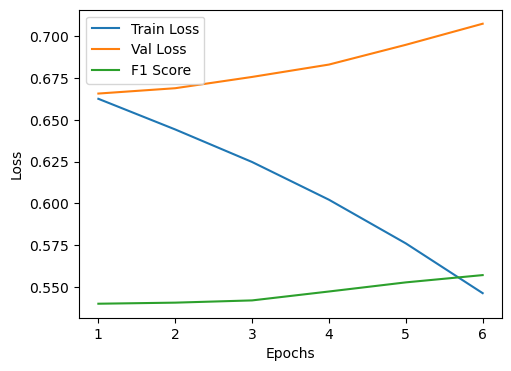




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[5043 1377]
 [1380 3724]] 

Accuracy: 76.1 

F1 Score: 73.0 

Balanced accuracy: 75.8 

AUC Score: 75.8 


----- TEST -----

Confusion matrix
 [[454 260]
 [239 314]] 

Accuracy: 60.6 

F1 Score: 55.7 

Balanced accuracy: 60.2 

AUC Score: 60.2 

_______________________________________________________________________


In [75]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_glove.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_glove.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_glove, y_train, X_test_embeddings_glove, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_glove_train, accuracy_nn_glove_train, f1_nn_glove_train, balaccuracy_nn_glove_train, rocauc_nn_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_nn_glove_test, accuracy_nn_glove_test, f1_nn_glove_test, balaccuracy_nn_glove_test, rocauc_nn_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

In [76]:
cm_nn_glove_train_tosave = repr(cm_nn_glove_train)
accuracy_nn_glove_train_tosave = repr(accuracy_nn_glove_train)
f1_nn_glove_train_tosave = repr(f1_nn_glove_train)
balaccuracy_nn_glove_train_tosave = repr(balaccuracy_nn_glove_train)
rocauc_nn_glove_train_tosave = repr(rocauc_nn_glove_train)

cm_nn_glove_test_tosave = repr(cm_nn_glove_test)
accuracy_nn_glove_test_tosave = repr(accuracy_nn_glove_test)
f1_nn_glove_test_tosave = repr(f1_nn_glove_test)
balaccuracy_nn_glove_test_tosave = repr(balaccuracy_nn_glove_test)
rocauc_nn_glove_test_tosave = repr(rocauc_nn_glove_test)


file = open("results_split/nn_glove_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_nn_glove_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_nn_glove_train_tosave + "\n" +
           "Train F1 = "+f1_nn_glove_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_nn_glove_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_nn_glove_train_tosave + "\n"+
           "Test CM = "+cm_nn_glove_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_nn_glove_test_tosave + "\n"+
           "Test F1 = "+f1_nn_glove_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_nn_glove_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_nn_glove_test_tosave)

file.close()

## Word2Vec

### Word2Vec + KNN

In [28]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_w2v_train, accuracy_knn_w2v_train, f1_knn_w2v_train, balaccuracy_knn_w2v_train, rocauc_knn_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_knn_w2v_test, accuracy_knn_w2v_test, f1_knn_w2v_test, balaccuracy_knn_w2v_test, rocauc_knn_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=6, weights=uniform;, score=0.429 total time=   0.2s
[CV 2/5] END metric=euclidean, n_neighbors=6, weights=uniform;, score=0.380 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=6, weights=uniform;, score=0.407 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=6, weights=uniform;, score=0.387 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=6, weights=uniform;, score=0.419 total time=   0.1s
[CV 1/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.509 total time=   3.0s
[CV 2/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.494 total time=   3.0s
[CV 3/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.508 total time=   3.0s
[CV 4/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.478 total time=   3.0s
[CV 5/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.514 to

In [29]:
cm_knn_w2v_train_tosave = repr(cm_knn_w2v_train)
accuracy_knn_w2v_train_tosave = repr(accuracy_knn_w2v_train)
f1_knn_w2v_train_tosave = repr(f1_knn_w2v_train)
balaccuracy_knn_w2v_train_tosave = repr(balaccuracy_knn_w2v_train)
rocauc_knn_w2v_train_tosave = repr(rocauc_knn_w2v_train)

cm_knn_w2v_test_tosave = repr(cm_knn_w2v_test)
accuracy_knn_w2v_test_tosave = repr(accuracy_knn_w2v_test)
f1_knn_w2v_test_tosave = repr(f1_knn_w2v_test)
balaccuracy_knn_w2v_test_tosave = repr(balaccuracy_knn_w2v_test)
rocauc_knn_w2v_test_tosave = repr(rocauc_knn_w2v_test)


file = open("results_split/knn_w2v_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_knn_w2v_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_knn_w2v_train_tosave + "\n" +
           "Train F1 = "+f1_knn_w2v_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_knn_w2v_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_knn_w2v_train_tosave + "\n"+
           "Test CM = "+cm_knn_w2v_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_knn_w2v_test_tosave + "\n"+
           "Test F1 = "+f1_knn_w2v_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_knn_w2v_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_knn_w2v_test_tosave)

file.close()

### Word2Vec + XGBoost

In [30]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_w2v_train, accuracy_xgb_w2v_train, f1_xgb_w2v_train, balaccuracy_xgb_w2v_train, rocauc_xgb_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_xgb_w2v_test, accuracy_xgb_w2v_test, f1_xgb_w2v_test, balaccuracy_xgb_w2v_test, rocauc_xgb_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=50, objective=reg:squarederror, subsample=0.5;, score=0.471 total time=   3.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=50, objective=reg:squarederror, subsample=0.5;, score=0.488 total time=   2.4s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=50, objective=reg:squarederror, subsample=0.5;, score=0.487 total time=   2.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=50, objective=reg:squarederror, subsample=0.5;, score=0.495 total time=   2.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=50, objective=reg:squarederror, subsample=0.5;, score=0.503 total time=   2.4s
[CV 1/5] END colsample_bytree=0.5, learning

In [39]:
cm_xgb_w2v_train_tosave = repr(cm_xgb_w2v_train)
accuracy_xgb_w2v_train_tosave = repr(accuracy_xgb_w2v_train)
f1_xgb_w2v_train_tosave = repr(f1_xgb_w2v_train)
balaccuracy_xgb_w2v_train_tosave = repr(balaccuracy_xgb_w2v_train)
rocauc_xgb_w2v_train_tosave = repr(rocauc_xgb_w2v_train)

cm_xgb_w2v_test_tosave = repr(cm_xgb_w2v_test)
accuracy_xgb_w2v_test_tosave = repr(accuracy_xgb_w2v_test)
f1_xgb_w2v_test_tosave = repr(f1_xgb_w2v_test)
balaccuracy_xgb_w2v_test_tosave = repr(balaccuracy_xgb_w2v_test)
rocauc_xgb_w2v_test_tosave = repr(rocauc_xgb_w2v_test)


file = open("results_split/xgb_w2v_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_xgb_w2v_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_xgb_w2v_train_tosave + "\n" +
           "Train F1 = "+f1_xgb_w2v_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_xgb_w2v_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_xgb_w2v_train_tosave + "\n"+
           "Test CM = "+cm_xgb_w2v_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_xgb_w2v_test_tosave + "\n"+
           "Test F1 = "+f1_xgb_w2v_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_xgb_w2v_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_xgb_w2v_test_tosave)

file.close()

### Word2Vec + Random Forest

In [ ]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_w2v_train, accuracy_rf_w2v_train, f1_rf_w2v_train, balaccuracy_rf_w2v_train, rocauc_rf_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_rf_w2v_test, accuracy_rf_w2v_test, f1_rf_w2v_test, balaccuracy_rf_w2v_test, rocauc_rf_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.446 total time=   1.1s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.458 total time=   1.1s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.480 total time=   1.1s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.422 total time=   1.1s
[CV 5/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.471 total time=   1.1s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=5, n_estimators=10;, score=0.408 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=5, n_estimators=10;, score=0.421 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=5, n_estimators=10;, score=0.397 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=5, n_est

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[6416    4]
 [   8 5096]] 

Accuracy: 99.9 

F1 Score: 99.9 

Balanced accuracy: 99.9 

AUC Score: 99.9 


----- TEST -----

Confusion matrix
 [[500 214]
 [320 233]] 

Accuracy: 57.9 

F1 Score: 46.6 

Balanced accuracy: 46.6 

AUC Score: 56.1 

_______________________________________________________________________


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [ ]:
cm_rf_w2v_train_tosave = repr(cm_rf_w2v_train)
accuracy_rf_w2v_train_tosave = repr(accuracy_rf_w2v_train)
f1_rf_w2v_train_tosave = repr(f1_rf_w2v_train)
balaccuracy_rf_w2v_train_tosave = repr(balaccuracy_rf_w2v_train)
rocauc_rf_w2v_train_tosave = repr(rocauc_rf_w2v_train)

cm_rf_w2v_test_tosave = repr(cm_rf_w2v_test)
accuracy_rf_w2v_test_tosave = repr(accuracy_rf_w2v_test)
f1_rf_w2v_test_tosave = repr(f1_rf_w2v_test)
balaccuracy_rf_w2v_test_tosave = repr(balaccuracy_rf_w2v_test)
rocauc_rf_w2v_test_tosave = repr(rocauc_rf_w2v_test)


file = open("results_split/rf_w2v_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_rf_w2v_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_rf_w2v_train_tosave + "\n" +
           "Train F1 = "+f1_rf_w2v_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_rf_w2v_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_rf_w2v_train_tosave + "\n"+
           "Test CM = "+cm_rf_w2v_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_rf_w2v_test_tosave + "\n"+
           "Test F1 = "+f1_rf_w2v_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_rf_w2v_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_rf_w2v_test_tosave)

file.close()

### Word2Vec + SVC

In [ ]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_w2v_train, accuracy_svc_w2v_train, f1_svc_w2v_train, balaccuracy_svc_w2v_train, rocauc_svc_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_svc_w2v_test, accuracy_svc_w2v_test, f1_svc_w2v_test, balaccuracy_svc_w2v_test, rocauc_svc_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.492 total time=  11.8s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.486 total time=  11.6s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.495 total time=  11.7s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.495 total time=  11.4s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.498 total time=  11.7s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.465 total time=  12.8s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.456 total time=  12.7s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.450 total time=  12.7s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.463 total time=  12.3s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.449 total time=  12.4s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.518 total time=  14.7s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

In [ ]:
cm_svc_w2v_train_tosave = repr(cm_svc_w2v_train)
accuracy_svc_w2v_train_tosave = repr(accuracy_svc_w2v_train)
f1_svc_w2v_train_tosave = repr(f1_svc_w2v_train)
balaccuracy_svc_w2v_train_tosave = repr(balaccuracy_svc_w2v_train)
rocauc_svc_w2v_train_tosave = repr(rocauc_svc_w2v_train)

cm_svc_w2v_test_tosave = repr(cm_svc_w2v_test)
accuracy_svc_w2v_test_tosave = repr(accuracy_svc_w2v_test)
f1_svc_w2v_test_tosave = repr(f1_svc_w2v_test)
balaccuracy_svc_w2v_test_tosave = repr(balaccuracy_svc_w2v_test)
rocauc_svc_w2v_test_tosave = repr(rocauc_svc_w2v_test)


file = open("results_split/svc_w2v_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_svc_w2v_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_svc_w2v_train_tosave + "\n" +
           "Train F1 = "+f1_svc_w2v_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_svc_w2v_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_svc_w2v_train_tosave + "\n"+
           "Test CM = "+cm_svc_w2v_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_svc_w2v_test_tosave + "\n"+
           "Test F1 = "+f1_svc_w2v_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_svc_w2v_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_svc_w2v_test_tosave)

file.close()

### Word2Vec + Logistic Regression

In [ ]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_w2v_train, accuracy_lr_w2v_train, f1_lr_w2v_train, balaccuracy_lr_w2v_train, rocauc_lr_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_lr_w2v_test, accuracy_lr_w2v_test, f1_lr_w2v_test, balaccuracy_lr_w2v_test, rocauc_lr_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.8300000000000001, penalty=l1, solver=saga;, score=0.508 total time=   0.5s
[CV 2/5] END C=0.8300000000000001, penalty=l1, solver=saga;, score=0.486 total time=   0.5s
[CV 3/5] END C=0.8300000000000001, penalty=l1, solver=saga;, score=0.506 total time=   0.5s
[CV 4/5] END C=0.8300000000000001, penalty=l1, solver=saga;, score=0.499 total time=   0.6s
[CV 5/5] END C=0.8300000000000001, penalty=l1, solver=saga;, score=0.507 total time=   0.6s
[CV 1/5] END ....C=0.81, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.81, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.81, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.81, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.81, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.46, penalty=none, solver=liblinear;, score=nan total tim

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.13, penalty=none, solver=saga;, score=0.499 total time=   0.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END .C=0.13, penalty=none, solver=saga;, score=0.497 total time=   0.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END .C=0.13, penalty=none, solver=saga;, score=0.505 total time=   0.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END .C=0.13, penalty=none, solver=saga;, score=0.499 total time=   0.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END .C=0.13, penalty=none, solver=saga;, score=0.511 total time=   0.6s
[CV 1/5] END C=0.61, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.61, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.61, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.61, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.61, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.79, penalty=none, solver=sag;, score=0.499 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.79, penalty=none, solver=sag;, score=0.497 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.79, penalty=none, solver=sag;, score=0.505 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.79, penalty=none, solver=sag;, score=0.499 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.79, penalty=none, solver=sag;, score=0.511 total time=   0.4s
[CV 1/5] END C=0.59, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.59, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.59, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.59, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.59, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END ...C=0.87, penalty=l2, solver=saga;, score=0.508 total time=   0.4s
[CV 2/5] END ...C=0.87, penalty=l2, solver=saga;, score=0.498 total time=   0.4s
[CV 3/5] END ...C=0.87, penalty=l2, solver=saga;, score=0.502 total time=   0.4s
[CV 4/5] END ...C=0.87, penalty=l2, solver=saga;, score=0.498 total time=   0.4s
[CV 5/5] END ...C=0.87, penalty=l2, solver=saga;, score=0.516 total time=   0.4s
[CV 1/5] END C=0.81, penalty=elasticnet, solver=lbfgs;, score=nan tot

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.49, penalty=none, solver=sag;, score=0.499 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.49, penalty=none, solver=sag;, score=0.497 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.49, penalty=none, solver=sag;, score=0.505 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.49, penalty=none, solver=sag;, score=0.499 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.49, penalty=none, solver=sag;, score=0.511 total time=   0.4s
[CV 1/5] END C=0.17, penalty=none, solver=lbfgs;, score=0.499 total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.17, penalty=none, solver=lbfgs;, score=0.497 total time=   0.0s
[CV 3/5] END C=0.17, penalty=none, solver=lbfgs;, score=0.505 total time=   0.0s
[CV 4/5] END C=0.17, penalty=none, solver=lbfgs;, score=0.499 total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.17, penalty=none, solver=lbfgs;, score=0.511 total time=   0.0s
[CV 1/5] END ....C=0.67, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.67, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.67, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.67, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.67, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.53, penalty=none, solver=newton-cg;, score=0.499 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.53, penalty=none, solver=newton-cg;, score=0.497 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.53, penalty=none, solver=newton-cg;, score=0.505 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.53, penalty=none, solver=newton-cg;, score=0.499 total time=   0.1s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.53, penalty=none, solver=newton-cg;, score=0.511 total time=   0.1s
[CV 1/5] END .....C=0.9, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .....C=0.9, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END .....C=0.9, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END .....C=0.9, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END .....C=0.9, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
Valu

Best parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.87} 




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4838 1582]
 [2624 2480]] 

Accuracy: 63.5 

F1 Score: 54.1 

Balanced accuracy: 54.1 

AUC Score: 62.0 


----- TEST -----

Confusion matrix
 [[540 174]
 [311 242]] 

Accuracy: 61.7 

F1 Score: 49.9 

Balanced accuracy: 49.9 

AUC Score: 59.7 

_______________________________________________________________________


In [ ]:
cm_lr_w2v_train_tosave = repr(cm_lr_w2v_train)
accuracy_lr_w2v_train_tosave = repr(accuracy_lr_w2v_train)
f1_lr_w2v_train_tosave = repr(f1_lr_w2v_train)
balaccuracy_lr_w2v_train_tosave = repr(balaccuracy_lr_w2v_train)
rocauc_lr_w2v_train_tosave = repr(rocauc_lr_w2v_train)

cm_lr_w2v_test_tosave = repr(cm_lr_w2v_test)
accuracy_lr_w2v_test_tosave = repr(accuracy_lr_w2v_test)
f1_lr_w2v_test_tosave = repr(f1_lr_w2v_test)
balaccuracy_lr_w2v_test_tosave = repr(balaccuracy_lr_w2v_test)
rocauc_lr_w2v_test_tosave = repr(rocauc_lr_w2v_test)


file = open("results_split/lr_w2v_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_lr_w2v_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_lr_w2v_train_tosave + "\n" +
           "Train F1 = "+f1_lr_w2v_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_lr_w2v_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_lr_w2v_train_tosave + "\n"+
           "Test CM = "+cm_lr_w2v_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_lr_w2v_test_tosave + "\n"+
           "Test F1 = "+f1_lr_w2v_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_lr_w2v_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_lr_w2v_test_tosave)

file.close()

### Word2Vec + Neural Network

Epoch 1/15 | Train Loss: 0.6641 | Val Loss: 0.6602 | F1 Score: 0.5647 | Balanced Accuracy: 0.6123 | AUC: 0.6123
Epoch 2/15 | Train Loss: 0.6487 | Val Loss: 0.6617 | F1 Score: 0.5575 | Balanced Accuracy: 0.6076 | AUC: 0.6076
Epoch 3/15 | Train Loss: 0.6376 | Val Loss: 0.6652 | F1 Score: 0.5570 | Balanced Accuracy: 0.6115 | AUC: 0.6115
Epoch 4/15 | Train Loss: 0.6240 | Val Loss: 0.6709 | F1 Score: 0.5506 | Balanced Accuracy: 0.6065 | AUC: 0.6065
Epoch 5/15 | Train Loss: 0.6077 | Val Loss: 0.6777 | F1 Score: 0.5426 | Balanced Accuracy: 0.6011 | AUC: 0.6011
Epoch 6/15 | Train Loss: 0.5886 | Val Loss: 0.6861 | F1 Score: 0.5460 | Balanced Accuracy: 0.5990 | AUC: 0.5990
Early stopping triggered. No improvement in 5 epochs.


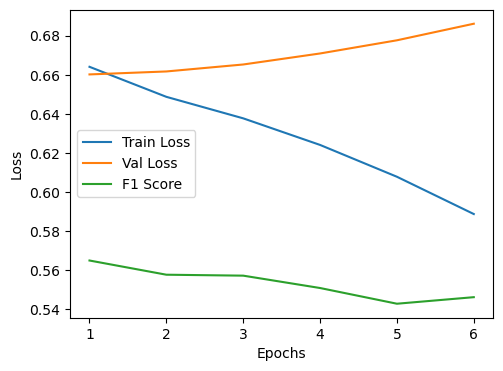




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4710 1710]
 [1659 3445]] 

Accuracy: 70.8 

F1 Score: 67.2 

Balanced accuracy: 70.4 

AUC Score: 70.4 


----- TEST -----

Confusion matrix
 [[468 246]
 [253 300]] 

Accuracy: 60.6 

F1 Score: 54.6 

Balanced accuracy: 59.9 

AUC Score: 59.9 

_______________________________________________________________________


In [ ]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_word2vec.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_word2vec.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_word2vec, y_train, X_test_embeddings_word2vec, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_w2v_train, accuracy_nn_w2v_train, f1_nn_w2v_train, balaccuracy_nn_w2v_train, rocauc_nn_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_nn_w2v_test, accuracy_nn_w2v_test, f1_nn_w2v_test, balaccuracy_nn_w2v_test, rocauc_nn_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

In [ ]:
cm_nn_w2v_train_tosave = repr(cm_nn_w2v_train)
accuracy_nn_w2v_train_tosave = repr(accuracy_nn_w2v_train)
f1_nn_w2v_train_tosave = repr(f1_nn_w2v_train)
balaccuracy_nn_w2v_train_tosave = repr(balaccuracy_nn_w2v_train)
rocauc_nn_w2v_train_tosave = repr(rocauc_nn_w2v_train)

cm_nn_w2v_test_tosave = repr(cm_nn_w2v_test)
accuracy_nn_w2v_test_tosave = repr(accuracy_nn_w2v_test)
f1_nn_w2v_test_tosave = repr(f1_nn_w2v_test)
balaccuracy_nn_w2v_test_tosave = repr(balaccuracy_nn_w2v_test)
rocauc_nn_w2v_test_tosave = repr(rocauc_nn_w2v_test)


file = open("results_split/nn_w2v_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_nn_w2v_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_nn_w2v_train_tosave + "\n" +
           "Train F1 = "+f1_nn_w2v_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_nn_w2v_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_nn_w2v_train_tosave + "\n"+
           "Test CM = "+cm_nn_w2v_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_nn_w2v_test_tosave + "\n"+
           "Test F1 = "+f1_nn_w2v_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_nn_w2v_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_nn_w2v_test_tosave)

file.close()

## GPT2

### GPT2 + KNN

In [41]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_gpt2_train, accuracy_knn_gpt2_train, f1_knn_gpt2_train, balaccuracy_knn_gpt2_train, rocauc_knn_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_knn_gpt2_test, accuracy_knn_gpt2_test, f1_knn_gpt2_test, balaccuracy_knn_gpt2_test, rocauc_knn_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=6, weights=distance;, score=0.512 total time=   0.3s
[CV 2/5] END metric=euclidean, n_neighbors=6, weights=distance;, score=0.460 total time=   0.3s
[CV 3/5] END metric=euclidean, n_neighbors=6, weights=distance;, score=0.514 total time=   0.3s
[CV 4/5] END metric=euclidean, n_neighbors=6, weights=distance;, score=0.433 total time=   0.2s
[CV 5/5] END metric=euclidean, n_neighbors=6, weights=distance;, score=0.501 total time=   0.3s
[CV 1/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.502 total time=   7.7s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.466 total time=   7.5s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.516 total time=   7.5s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.431 total time=   7.5s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.5

In [42]:
cm_knn_gpt2_train_tosave = repr(cm_knn_gpt2_train)
accuracy_knn_gpt2_train_tosave = repr(accuracy_knn_gpt2_train)
f1_knn_gpt2_train_tosave = repr(f1_knn_gpt2_train)
balaccuracy_knn_gpt2_train_tosave = repr(balaccuracy_knn_gpt2_train)
rocauc_knn_gpt2_train_tosave = repr(rocauc_knn_gpt2_train)

cm_knn_gpt2_test_tosave = repr(cm_knn_gpt2_test)
accuracy_knn_gpt2_test_tosave = repr(accuracy_knn_gpt2_test)
f1_knn_gpt2_test_tosave = repr(f1_knn_gpt2_test)
balaccuracy_knn_gpt2_test_tosave = repr(balaccuracy_knn_gpt2_test)
rocauc_knn_gpt2_test_tosave = repr(rocauc_knn_gpt2_test)


file = open("results_split/knn_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_knn_gpt2_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_knn_gpt2_train_tosave + "\n" +
           "Train F1 = "+f1_knn_gpt2_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_knn_gpt2_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_knn_gpt2_train_tosave + "\n"+
           "Test CM = "+cm_knn_gpt2_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_knn_gpt2_test_tosave + "\n"+
           "Test F1 = "+f1_knn_gpt2_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_knn_gpt2_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_knn_gpt2_test_tosave)

file.close()

### GPT2 + XGBoost

In [43]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_gpt2_train, accuracy_xgb_gpt2_train, f1_xgb_gpt2_train, balaccuracy_xgb_gpt2_train, rocauc_xgb_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_xgb_gpt2_test, accuracy_xgb_gpt2_test, f1_xgb_gpt2_test, balaccuracy_xgb_gpt2_test, rocauc_xgb_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=200, objective=reg:squarederror, subsample=0.5;, score=0.489 total time=  16.6s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=200, objective=reg:squarederror, subsample=0.5;, score=0.487 total time=  16.2s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=200, objective=reg:squarederror, subsample=0.5;, score=0.494 total time=  16.4s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=200, objective=reg:squarederror, subsample=0.5;, score=0.484 total time=  16.6s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=200, objective=reg:squarederror, subsample=0.5;, score=0.497 total time=  16.5s
[CV 1/5] END colsample_bytree=0.7, lea

In [44]:
cm_xgb_gpt2_train_tosave = repr(cm_xgb_gpt2_train)
accuracy_xgb_gpt2_train_tosave = repr(accuracy_xgb_gpt2_train)
f1_xgb_gpt2_train_tosave = repr(f1_xgb_gpt2_train)
balaccuracy_xgb_gpt2_train_tosave = repr(balaccuracy_xgb_gpt2_train)
rocauc_xgb_gpt2_train_tosave = repr(rocauc_xgb_gpt2_train)

cm_xgb_gpt2_test_tosave = repr(cm_xgb_gpt2_test)
accuracy_xgb_gpt2_test_tosave = repr(accuracy_xgb_gpt2_test)
f1_xgb_gpt2_test_tosave = repr(f1_xgb_gpt2_test)
balaccuracy_xgb_gpt2_test_tosave = repr(balaccuracy_xgb_gpt2_test)
rocauc_xgb_gpt2_test_tosave = repr(rocauc_xgb_gpt2_test)


file = open("results_split/xgb_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_xgb_gpt2_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_xgb_gpt2_train_tosave + "\n" +
           "Train F1 = "+f1_xgb_gpt2_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_xgb_gpt2_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_xgb_gpt2_train_tosave + "\n"+
           "Test CM = "+cm_xgb_gpt2_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_xgb_gpt2_test_tosave + "\n"+
           "Test F1 = "+f1_xgb_gpt2_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_xgb_gpt2_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_xgb_gpt2_test_tosave)

file.close()

### GPT2 + Random Forest

In [45]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_gpt2_train, accuracy_rf_gpt2_train, f1_rf_gpt2_train, balaccuracy_rf_gpt2_train, rocauc_rf_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_rf_gpt2_test, accuracy_rf_gpt2_test, f1_rf_gpt2_test, balaccuracy_rf_gpt2_test, rocauc_rf_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=25;, score=0.391 total time=   1.5s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=25;, score=0.406 total time=   1.5s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=25;, score=0.389 total time=   1.5s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=25;, score=0.381 total time=   1.5s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=25;, score=0.385 total time=   1.5s
[CV 1/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.449 total time=   2.2s
[CV 2/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.474 total time=   2.2s
[CV 3/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.454 total time=   2.2s
[CV 4/5] END bootstrap=False, max_depth=50, max_features=10, n_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[6420    0]
 [   4 5100]] 

Accuracy: 100.0 

F1 Score: 100.0 

Balanced accuracy: 100.0 

AUC Score: 100.0 


----- TEST -----

Confusion matrix
 [[506 208]
 [314 239]] 

Accuracy: 58.8 

F1 Score: 47.8 

Balanced accuracy: 47.8 

AUC Score: 57.0 

_______________________________________________________________________


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [46]:
cm_rf_gpt2_train_tosave = repr(cm_rf_gpt2_train)
accuracy_rf_gpt2_train_tosave = repr(accuracy_rf_gpt2_train)
f1_rf_gpt2_train_tosave = repr(f1_rf_gpt2_train)
balaccuracy_rf_gpt2_train_tosave = repr(balaccuracy_rf_gpt2_train)
rocauc_rf_gpt2_train_tosave = repr(rocauc_rf_gpt2_train)

cm_rf_gpt2_test_tosave = repr(cm_rf_gpt2_test)
accuracy_rf_gpt2_test_tosave = repr(accuracy_rf_gpt2_test)
f1_rf_gpt2_test_tosave = repr(f1_rf_gpt2_test)
balaccuracy_rf_gpt2_test_tosave = repr(balaccuracy_rf_gpt2_test)
rocauc_rf_gpt2_test_tosave = repr(rocauc_rf_gpt2_test)


file = open("results_split/rf_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_rf_gpt2_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_rf_gpt2_train_tosave + "\n" +
           "Train F1 = "+f1_rf_gpt2_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_rf_gpt2_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_rf_gpt2_train_tosave + "\n"+
           "Test CM = "+cm_rf_gpt2_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_rf_gpt2_test_tosave + "\n"+
           "Test F1 = "+f1_rf_gpt2_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_rf_gpt2_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_rf_gpt2_test_tosave)

file.close()

### GPT2 + SVC

In [47]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_gpt2_train, accuracy_svc_gpt2_train, f1_svc_gpt2_train, balaccuracy_svc_gpt2_train, rocauc_svc_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_svc_gpt2_test, accuracy_svc_gpt2_test, f1_svc_gpt2_test, balaccuracy_svc_gpt2_test, rocauc_svc_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.526 total time=  24.7s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.518 total time=  24.9s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.506 total time=  24.7s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.498 total time=  24.9s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.541 total time=  25.0s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.514 total time=  25.6s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.502 total time=  25.6s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.507 total time=  25.6s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.494 total time=  25.5s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.512 total time=  25.6s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.510 total time=  29.8s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

In [48]:
cm_svc_gpt2_train_tosave = repr(cm_svc_gpt2_train)
accuracy_svc_gpt2_train_tosave = repr(accuracy_svc_gpt2_train)
f1_svc_gpt2_train_tosave = repr(f1_svc_gpt2_train)
balaccuracy_svc_gpt2_train_tosave = repr(balaccuracy_svc_gpt2_train)
rocauc_svc_gpt2_train_tosave = repr(rocauc_svc_gpt2_train)

cm_svc_gpt2_test_tosave = repr(cm_svc_gpt2_test)
accuracy_svc_gpt2_test_tosave = repr(accuracy_svc_gpt2_test)
f1_svc_gpt2_test_tosave = repr(f1_svc_gpt2_test)
balaccuracy_svc_gpt2_test_tosave = repr(balaccuracy_svc_gpt2_test)
rocauc_svc_gpt2_test_tosave = repr(rocauc_svc_gpt2_test)


file = open("results_split/svc_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_svc_gpt2_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_svc_gpt2_train_tosave + "\n" +
           "Train F1 = "+f1_svc_gpt2_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_svc_gpt2_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_svc_gpt2_train_tosave + "\n"+
           "Test CM = "+cm_svc_gpt2_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_svc_gpt2_test_tosave + "\n"+
           "Test F1 = "+f1_svc_gpt2_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_svc_gpt2_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_svc_gpt2_test_tosave)

file.close()

### GPT2 + Logistic Regression

In [49]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_gpt2_train, accuracy_lr_gpt2_train, f1_lr_gpt2_train, balaccuracy_lr_gpt2_train, rocauc_lr_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_lr_gpt2_test, accuracy_lr_gpt2_test, f1_lr_gpt2_test, balaccuracy_lr_gpt2_test, rocauc_lr_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...C=0.13, penalty=l1, solver=saga;, score=0.295 total time=   1.9s
[CV 2/5] END ...C=0.13, penalty=l1, solver=saga;, score=0.276 total time=   2.8s
[CV 3/5] END ...C=0.13, penalty=l1, solver=saga;, score=0.308 total time=   2.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.13, penalty=l1, solver=saga;, score=0.292 total time=   5.5s
[CV 5/5] END ...C=0.13, penalty=l1, solver=saga;, score=0.254 total time=   2.7s
[CV 1/5] END C=0.63, penalty=l2, solver=newton-cg;, score=0.519 total time=   0.5s
[CV 2/5] END C=0.63, penalty=l2, solver=newton-cg;, score=0.523 total time=   0.5s
[CV 3/5] END C=0.63, penalty=l2, solver=newton-cg;, score=0.502 total time=   0.5s
[CV 4/5] END C=0.63, penalty=l2, solver=newton-cg;, score=0.501 total time=   0.5s
[CV 5/5] END C=0.63, penalty=l2, solver=newton-cg;, score=0.536 total time=   0.5s
[CV 1/5] END .......C=0.2, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END .......C=0.2, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END .......C=0.2, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END .......C=0.2, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END .......C=0.2, penalty=l1, solver=sag;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=0.91, penalty=l2, solver=lbfgs;, score=0.527 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..C=0.91, penalty=l2, solver=lbfgs;, score=0.529 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..C=0.91, penalty=l2, solver=lbfgs;, score=0.513 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..C=0.91, penalty=l2, solver=lbfgs;, score=0.509 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..C=0.91, penalty=l2, solver=lbfgs;, score=0.538 total time=   0.3s
[CV 1/5] END ....C=0.54, penalty=l2, solver=sag;, score=0.519 total time=   1.0s
[CV 2/5] END ....C=0.54, penalty=l2, solver=sag;, score=0.520 total time=   1.2s
[CV 3/5] END ....C=0.54, penalty=l2, solver=sag;, score=0.501 total time=   1.4s
[CV 4/5] END ....C=0.54, penalty=l2, solver=sag;, score=0.496 total time=   1.4s
[CV 5/5] END ....C=0.54, penalty=l2, solver=sag;, score=0.534 total time=   1.3s
[CV 1/5] END ...C=0.78, penalty=l2, solver=saga;, score=0.524 total time=   3.4s
[CV 2/5] END ...C=0.78, penalty=l2, solver=saga;, score=0.530 total time=   3.7s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.78, penalty=l2, solver=saga;, score=0.509 total time=   4.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.78, penalty=l2, solver=saga;, score=0.506 total time=   4.5s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=0.78, penalty=l2, solver=saga;, score=0.535 total time=   4.5s
[CV 1/5] END C=0.09, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.09, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.09, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.09, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.09, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ......C=0.36, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END ......C=0.36, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END ......C=0.36, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END ......C=0.36, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END ......C=0.36, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.76, penalty=none, solver=liblinear;, score=nan total

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=0.75, penalty=l2, solver=lbfgs;, score=0.525 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..C=0.75, penalty=l2, solver=lbfgs;, score=0.526 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..C=0.75, penalty=l2, solver=lbfgs;, score=0.508 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..C=0.75, penalty=l2, solver=lbfgs;, score=0.506 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..C=0.75, penalty=l2, solver=lbfgs;, score=0.535 total time=   0.2s
[CV 1/5] END C=0.04, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.04, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.04, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.04, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.04, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.4, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.4, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.4, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.4, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.4, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.76, penalty=none, solver=saga;, score=0.539 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END .C=0.76, penalty=none, solver=saga;, score=0.525 total time=   4.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END .C=0.76, penalty=none, solver=saga;, score=0.515 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END .C=0.76, penalty=none, solver=saga;, score=0.510 total time=   4.6s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .C=0.76, penalty=none, solver=saga;, score=0.552 total time=   4.3s
[CV 1/5] END C=0.02, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.02, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.02, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.02, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.02, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.99, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.99, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.99, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.99, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.99, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.32, penalty=none, solver=lbfgs;, score=0.534 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.32, penalty=none, solver=lbfgs;, score=0.528 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.32, penalty=none, solver=lbfgs;, score=0.505 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.32, penalty=none, solver=lbfgs;, score=0.504 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:


[CV 5/5] END C=0.32, penalty=none, solver=lbfgs;, score=0.550 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best parameters: {'solver': 'saga', 'penalty': 'none', 'C': 0.76} 




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4922 1498]
 [2263 2841]] 

Accuracy: 67.4 

F1 Score: 60.2 

Balanced accuracy: 60.2 

AUC Score: 66.2 


----- TEST -----

Confusion matrix
 [[507 207]
 [275 278]] 

Accuracy: 62.0 

F1 Score: 53.6 

Balanced accuracy: 53.6 

AUC Score: 60.6 

_______________________________________________________________________


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [50]:
cm_lr_gpt2_train_tosave = repr(cm_lr_gpt2_train)
accuracy_lr_gpt2_train_tosave = repr(accuracy_lr_gpt2_train)
f1_lr_gpt2_train_tosave = repr(f1_lr_gpt2_train)
balaccuracy_lr_gpt2_train_tosave = repr(balaccuracy_lr_gpt2_train)
rocauc_lr_gpt2_train_tosave = repr(rocauc_lr_gpt2_train)

cm_lr_gpt2_test_tosave = repr(cm_lr_gpt2_test)
accuracy_lr_gpt2_test_tosave = repr(accuracy_lr_gpt2_test)
f1_lr_gpt2_test_tosave = repr(f1_lr_gpt2_test)
balaccuracy_lr_gpt2_test_tosave = repr(balaccuracy_lr_gpt2_test)
rocauc_lr_gpt2_test_tosave = repr(rocauc_lr_gpt2_test)


file = open("results_split/lr_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_lr_gpt2_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_lr_gpt2_train_tosave + "\n" +
           "Train F1 = "+f1_lr_gpt2_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_lr_gpt2_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_lr_gpt2_train_tosave + "\n"+
           "Test CM = "+cm_lr_gpt2_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_lr_gpt2_test_tosave + "\n"+
           "Test F1 = "+f1_lr_gpt2_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_lr_gpt2_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_lr_gpt2_test_tosave)

file.close()

### GPT2 + Neural Network

Epoch 1/15 | Train Loss: 0.6657 | Val Loss: 0.6535 | F1 Score: 0.5510 | Balanced Accuracy: 0.6060 | AUC: 0.6060
Epoch 2/15 | Train Loss: 0.6475 | Val Loss: 0.6540 | F1 Score: 0.5476 | Balanced Accuracy: 0.6052 | AUC: 0.6052
Epoch 3/15 | Train Loss: 0.6362 | Val Loss: 0.6575 | F1 Score: 0.5443 | Balanced Accuracy: 0.6015 | AUC: 0.6015
Epoch 4/15 | Train Loss: 0.6253 | Val Loss: 0.6622 | F1 Score: 0.5411 | Balanced Accuracy: 0.5961 | AUC: 0.5961
Epoch 5/15 | Train Loss: 0.6099 | Val Loss: 0.6699 | F1 Score: 0.5448 | Balanced Accuracy: 0.6022 | AUC: 0.6022
Epoch 6/15 | Train Loss: 0.5906 | Val Loss: 0.6821 | F1 Score: 0.5456 | Balanced Accuracy: 0.5966 | AUC: 0.5966
Early stopping triggered. No improvement in 5 epochs.


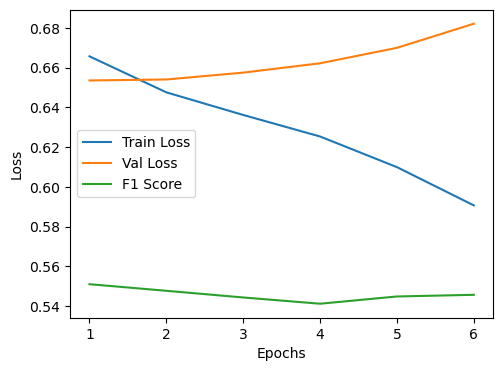




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4683 1737]
 [1796 3308]] 

Accuracy: 69.3 

F1 Score: 65.2 

Balanced accuracy: 68.9 

AUC Score: 68.9 


----- TEST -----

Confusion matrix
 [[462 252]
 [251 302]] 

Accuracy: 60.3 

F1 Score: 54.6 

Balanced accuracy: 59.7 

AUC Score: 59.7 

_______________________________________________________________________


In [51]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_gpt2.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_gpt2.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_gpt2, y_train, X_test_embeddings_gpt2, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_gpt2_train, accuracy_nn_gpt2_train, f1_nn_gpt2_train, balaccuracy_nn_gpt2_train, rocauc_nn_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_nn_gpt2_test, accuracy_nn_gpt2_test, f1_nn_gpt2_test, balaccuracy_nn_gpt2_test, rocauc_nn_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

In [52]:
cm_nn_gpt2_train_tosave = repr(cm_nn_gpt2_train)
accuracy_nn_gpt2_train_tosave = repr(accuracy_nn_gpt2_train)
f1_nn_gpt2_train_tosave = repr(f1_nn_gpt2_train)
balaccuracy_nn_gpt2_train_tosave = repr(balaccuracy_nn_gpt2_train)
rocauc_nn_gpt2_train_tosave = repr(rocauc_nn_gpt2_train)

cm_nn_gpt2_test_tosave = repr(cm_nn_gpt2_test)
accuracy_nn_gpt2_test_tosave = repr(accuracy_nn_gpt2_test)
f1_nn_gpt2_test_tosave = repr(f1_nn_gpt2_test)
balaccuracy_nn_gpt2_test_tosave = repr(balaccuracy_nn_gpt2_test)
rocauc_nn_gpt2_test_tosave = repr(rocauc_nn_gpt2_test)


file = open("results_split/nn_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_nn_gpt2_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_nn_gpt2_train_tosave + "\n" +
           "Train F1 = "+f1_nn_gpt2_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_nn_gpt2_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_nn_gpt2_train_tosave + "\n"+
           "Test CM = "+cm_nn_gpt2_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_nn_gpt2_test_tosave + "\n"+
           "Test F1 = "+f1_nn_gpt2_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_nn_gpt2_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_nn_gpt2_test_tosave)

file.close()

## RoBERTa

### RoBERTa + KNN

In [53]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_roberta_train, accuracy_knn_roberta_train, f1_knn_roberta_train, balaccuracy_knn_roberta_train, rocauc_knn_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_knn_roberta_test, accuracy_knn_roberta_test, f1_knn_roberta_test, balaccuracy_knn_roberta_test, rocauc_knn_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.517 total time=   7.6s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.486 total time=   7.6s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.538 total time=   7.7s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.493 total time=   7.5s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.501 total time=   7.5s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.523 total time=   7.5s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.484 total time=   7.6s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.522 total time=   7.6s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.497 total time=   7.5s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.507 to

In [54]:
cm_knn_roberta_train_tosave = repr(cm_knn_roberta_train)
accuracy_knn_roberta_train_tosave = repr(accuracy_knn_roberta_train)
f1_knn_roberta_train_tosave = repr(f1_knn_roberta_train)
balaccuracy_knn_roberta_train_tosave = repr(balaccuracy_knn_roberta_train)
rocauc_knn_roberta_train_tosave = repr(rocauc_knn_roberta_train)

cm_knn_roberta_test_tosave = repr(cm_knn_roberta_test)
accuracy_knn_roberta_test_tosave = repr(accuracy_knn_roberta_test)
f1_knn_roberta_test_tosave = repr(f1_knn_roberta_test)
balaccuracy_knn_roberta_test_tosave = repr(balaccuracy_knn_roberta_test)
rocauc_knn_roberta_test_tosave = repr(rocauc_knn_roberta_test)


file = open("results_split/knn_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_knn_roberta_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_knn_roberta_train_tosave + "\n" +
           "Train F1 = "+f1_knn_roberta_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_knn_roberta_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_knn_roberta_train_tosave + "\n"+
           "Test CM = "+cm_knn_roberta_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_knn_roberta_test_tosave + "\n"+
           "Test F1 = "+f1_knn_roberta_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_knn_roberta_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_knn_roberta_test_tosave)

file.close()

### RoBERTa + XGBoost

In [55]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_roberta_train, accuracy_xgb_roberta_train, f1_xgb_roberta_train, balaccuracy_xgb_roberta_train, rocauc_xgb_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_xgb_roberta_test, accuracy_xgb_roberta_test, f1_xgb_roberta_test, balaccuracy_xgb_roberta_test, rocauc_xgb_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.499 total time= 1.1min
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.518 total time= 1.1min
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.496 total time= 1.1min
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.514 total time= 1.1min
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.524 total time= 1.1min
[CV 1/5] END colsample_bytree=0.7, lea

In [56]:
cm_xgb_roberta_train_tosave = repr(cm_xgb_roberta_train)
accuracy_xgb_roberta_train_tosave = repr(accuracy_xgb_roberta_train)
f1_xgb_roberta_train_tosave = repr(f1_xgb_roberta_train)
balaccuracy_xgb_roberta_train_tosave = repr(balaccuracy_xgb_roberta_train)
rocauc_xgb_roberta_train_tosave = repr(rocauc_xgb_roberta_train)

cm_xgb_roberta_test_tosave = repr(cm_xgb_roberta_test)
accuracy_xgb_roberta_test_tosave = repr(accuracy_xgb_roberta_test)
f1_xgb_roberta_test_tosave = repr(f1_xgb_roberta_test)
balaccuracy_xgb_roberta_test_tosave = repr(balaccuracy_xgb_roberta_test)
rocauc_xgb_roberta_test_tosave = repr(rocauc_xgb_roberta_test)


file = open("results_split/xgb_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_xgb_roberta_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_xgb_roberta_train_tosave + "\n" +
           "Train F1 = "+f1_xgb_roberta_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_xgb_roberta_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_xgb_roberta_train_tosave + "\n"+
           "Test CM = "+cm_xgb_roberta_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_xgb_roberta_test_tosave + "\n"+
           "Test F1 = "+f1_xgb_roberta_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_xgb_roberta_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_xgb_roberta_test_tosave)

file.close()

### RoBERTa + Random Forest

In [57]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_roberta_train, accuracy_rf_roberta_train, f1_rf_roberta_train, balaccuracy_rf_roberta_train, rocauc_rf_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_rf_roberta_test, accuracy_rf_roberta_test, f1_rf_roberta_test, balaccuracy_rf_roberta_test, rocauc_rf_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.407 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.400 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.404 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.404 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.414 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.454 total time=   1.2s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.469 total time=   1.2s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.449 total time=   1.2s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=5, n_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[6420    0]
 [   4 5100]] 

Accuracy: 100.0 

F1 Score: 100.0 

Balanced accuracy: 100.0 

AUC Score: 100.0 


----- TEST -----

Confusion matrix
 [[524 190]
 [328 225]] 

Accuracy: 59.1 

F1 Score: 46.5 

Balanced accuracy: 46.5 

AUC Score: 57.0 

_______________________________________________________________________


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [58]:
cm_rf_roberta_train_tosave = repr(cm_rf_roberta_train)
accuracy_rf_roberta_train_tosave = repr(accuracy_rf_roberta_train)
f1_rf_roberta_train_tosave = repr(f1_rf_roberta_train)
balaccuracy_rf_roberta_train_tosave = repr(balaccuracy_rf_roberta_train)
rocauc_rf_roberta_train_tosave = repr(rocauc_rf_roberta_train)

cm_rf_roberta_test_tosave = repr(cm_rf_roberta_test)
accuracy_rf_roberta_test_tosave = repr(accuracy_rf_roberta_test)
f1_rf_roberta_test_tosave = repr(f1_rf_roberta_test)
balaccuracy_rf_roberta_test_tosave = repr(balaccuracy_rf_roberta_test)
rocauc_rf_roberta_test_tosave = repr(rocauc_rf_roberta_test)


file = open("results_split/rf_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_rf_roberta_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_rf_roberta_train_tosave + "\n" +
           "Train F1 = "+f1_rf_roberta_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_rf_roberta_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_rf_roberta_train_tosave + "\n"+
           "Test CM = "+cm_rf_roberta_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_rf_roberta_test_tosave + "\n"+
           "Test F1 = "+f1_rf_roberta_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_rf_roberta_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_rf_roberta_test_tosave)

file.close()

### RoBERTa + SVC

In [59]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_roberta_train, accuracy_svc_roberta_train, f1_svc_roberta_train, balaccuracy_svc_roberta_train, rocauc_svc_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_svc_roberta_test, accuracy_svc_roberta_test, f1_svc_roberta_test, balaccuracy_svc_roberta_test, rocauc_svc_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.533 total time=  24.6s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.515 total time=  24.6s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.505 total time=  24.5s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.515 total time=  24.4s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.532 total time=  24.6s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.002 total time=  27.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.000 total time=  27.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.000 total time=  27.3s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.002 total time=  28.4s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.000 total time=  26.9s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.000 total time=  31.4s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

In [60]:
cm_svc_roberta_train_tosave = repr(cm_svc_roberta_train)
accuracy_svc_roberta_train_tosave = repr(accuracy_svc_roberta_train)
f1_svc_roberta_train_tosave = repr(f1_svc_roberta_train)
balaccuracy_svc_roberta_train_tosave = repr(balaccuracy_svc_roberta_train)
rocauc_svc_roberta_train_tosave = repr(rocauc_svc_roberta_train)

cm_svc_roberta_test_tosave = repr(cm_svc_roberta_test)
accuracy_svc_roberta_test_tosave = repr(accuracy_svc_roberta_test)
f1_svc_roberta_test_tosave = repr(f1_svc_roberta_test)
balaccuracy_svc_roberta_test_tosave = repr(balaccuracy_svc_roberta_test)
rocauc_svc_roberta_test_tosave = repr(rocauc_svc_roberta_test)


file = open("results_split/svc_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_svc_roberta_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_svc_roberta_train_tosave + "\n" +
           "Train F1 = "+f1_svc_roberta_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_svc_roberta_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_svc_roberta_train_tosave + "\n"+
           "Test CM = "+cm_svc_roberta_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_svc_roberta_test_tosave + "\n"+
           "Test F1 = "+f1_svc_roberta_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_svc_roberta_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_svc_roberta_test_tosave)

file.close()

### RoBERTa + Logistic Regression

In [61]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_roberta_train, accuracy_lr_roberta_train, f1_lr_roberta_train, balaccuracy_lr_roberta_train, rocauc_lr_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_lr_roberta_test, accuracy_lr_roberta_test, f1_lr_roberta_test, balaccuracy_lr_roberta_test, rocauc_lr_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=0.9400000000000001, penalty=l2, solver=lbfgs;, score=0.540 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=0.9400000000000001, penalty=l2, solver=lbfgs;, score=0.513 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.9400000000000001, penalty=l2, solver=lbfgs;, score=0.508 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.9400000000000001, penalty=l2, solver=lbfgs;, score=0.501 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=0.9400000000000001, penalty=l2, solver=lbfgs;, score=0.540 total time=   0.3s
[CV 1/5] END C=0.12, penalty=l2, solver=liblinear;, score=0.481 total time=   0.6s
[CV 2/5] END C=0.12, penalty=l2, solver=liblinear;, score=0.472 total time=   0.5s
[CV 3/5] END C=0.12, penalty=l2, solver=liblinear;, score=0.477 total time=   0.6s
[CV 4/5] END C=0.12, penalty=l2, solver=liblinear;, score=0.477 total time=   0.6s
[CV 5/5] END C=0.12, penalty=l2, solver=liblinear;, score=0.487 total time=   0.5s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=0.31, penalty=l2, solver=lbfgs;, score=0.518 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..C=0.31, penalty=l2, solver=lbfgs;, score=0.511 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..C=0.31, penalty=l2, solver=lbfgs;, score=0.498 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..C=0.31, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..C=0.31, penalty=l2, solver=lbfgs;, score=0.521 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=0.27, penalty=l2, solver=lbfgs;, score=0.517 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..C=0.27, penalty=l2, solver=lbfgs;, score=0.508 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..C=0.27, penalty=l2, solver=lbfgs;, score=0.495 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..C=0.27, penalty=l2, solver=lbfgs;, score=0.495 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.27, penalty=l2, solver=lbfgs;, score=0.520 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.548 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.523 total time=   0.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.521 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.527 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.548 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.29, penalty=none, solver=sag;, score=0.546 total time=   3.9s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.29, penalty=none, solver=sag;, score=0.526 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.29, penalty=none, solver=sag;, score=0.525 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.29, penalty=none, solver=sag;, score=0.517 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.29, penalty=none, solver=sag;, score=0.560 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.51, penalty=none, solver=sag;, score=0.547 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.51, penalty=none, solver=sag;, score=0.526 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.51, penalty=none, solver=sag;, score=0.524 total time=   3.9s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.51, penalty=none, solver=sag;, score=0.518 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=0.51, penalty=none, solver=sag;, score=0.559 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=0.39, penalty=l2, solver=sag;, score=0.525 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=0.39, penalty=l2, solver=sag;, score=0.513 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=0.39, penalty=l2, solver=sag;, score=0.500 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=0.39, penalty=l2, solver=sag;, score=0.501 total time=   3.9s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=0.39, penalty=l2, solver=sag;, score=0.521 total time=   3.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.74, penalty=l2, solver=saga;, score=0.545 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.74, penalty=l2, solver=saga;, score=0.519 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.74, penalty=l2, solver=saga;, score=0.505 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.74, penalty=l2, solver=saga;, score=0.508 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=0.74, penalty=l2, solver=saga;, score=0.540 total time=   4.2s
[CV 1/5] END C=0.5, penalty=l2, solver=liblinear;, score=0.539 total time=   0.8s
[CV 2/5] END C=0.5, penalty=l2, solver=liblinear;, score=0.515 total time=   0.8s
[CV 3/5] END C=0.5, penalty=l2, solver=liblinear;, score=0.501 total time=   0.8s
[CV 4/5] END C=0.5, penalty=l2, solver=liblinear;, score=0.505 total time=   0.8s
[CV 5/5] END C=0.5, penalty=l2, solver=liblinear;, score=0.533 total time=   0.8s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.15, penalty=none, solver=newton-cg;, score=0.543 total time=  31.5s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.15, penalty=none, solver=newton-cg;, score=0.537 total time=  26.9s
[CV 3/5] END C=0.15, penalty=none, solver=newton-cg;, score=0.526 total time=  33.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.15, penalty=none, solver=newton-cg;, score=0.520 total time=  28.1s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.15, penalty=none, solver=newton-cg;, score=0.551 total time=  29.8s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.070 total time=   0.4s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.049 total time=   0.4s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.081 total time=   0.4s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.072 total time=   0.4s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.047 total time=   0.4s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.8200000000000001, penalty=l1, solver=saga;, score=0.520 total time=   6.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.8200000000000001, penalty=l1, solver=saga;, score=0.497 total time=   6.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.8200000000000001, penalty=l1, solver=saga;, score=0.496 total time=   6.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.8200000000000001, penalty=l1, solver=saga;, score=0.500 total time=   6.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.8200000000000001, penalty=l1, solver=saga;, score=0.521 total time=   6.2s
[CV 1/5] END C=0.61, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.61, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.61, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.61, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.61, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.543 total time=  31.5s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.537 total time=  26.9s
[CV 3/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.526 total time=  33.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.520 total time=  28.1s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.551 total time=  29.7s
[CV 1/5] END C=0.36, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.36, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.36, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.36, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.36, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.5700000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.5700000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.5700000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.5700000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.5700000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=

C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=0.04, penalty=l2, solver=lbfgs;, score=0.397 total time=   0.2s
[CV 2/5] END ..C=0.04, penalty=l2, solver=lbfgs;, score=0.412 total time=   0.2s
[CV 3/5] END ..C=0.04, penalty=l2, solver=lbfgs;, score=0.400 total time=   0.2s
[CV 4/5] END ..C=0.04, penalty=l2, solver=lbfgs;, score=0.404 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..C=0.04, penalty=l2, solver=lbfgs;, score=0.412 total time=   0.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.544 total time=   4.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.520 total time=   4.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.505 total time=   4.2s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.512 total time=   4.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(

[CV 5/5] END ...C=0.79, penalty=l2, solver=saga;, score=0.544 total time=   4.3s


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 0.15} 




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4897 1523]
 [2137 2967]] 

Accuracy: 68.2 

F1 Score: 61.9 

Balanced accuracy: 61.9 

AUC Score: 67.2 


----- TEST -----

Confusion matrix
 [[487 227]
 [279 274]] 

Accuracy: 60.1 

F1 Score: 52.0 

Balanced accuracy: 52.0 

AUC Score: 58.9 

_______________________________________________________________________


C:\Users\Wesub\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [62]:
cm_lr_roberta_train_tosave = repr(cm_lr_roberta_train)
accuracy_lr_roberta_train_tosave = repr(accuracy_lr_roberta_train)
f1_lr_roberta_train_tosave = repr(f1_lr_roberta_train)
balaccuracy_lr_roberta_train_tosave = repr(balaccuracy_lr_roberta_train)
rocauc_lr_roberta_train_tosave = repr(rocauc_lr_roberta_train)

cm_lr_roberta_test_tosave = repr(cm_lr_roberta_test)
accuracy_lr_roberta_test_tosave = repr(accuracy_lr_roberta_test)
f1_lr_roberta_test_tosave = repr(f1_lr_roberta_test)
balaccuracy_lr_roberta_test_tosave = repr(balaccuracy_lr_roberta_test)
rocauc_lr_roberta_test_tosave = repr(rocauc_lr_roberta_test)


file = open("results_split/lr_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_lr_roberta_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_lr_roberta_train_tosave + "\n" +
           "Train F1 = "+f1_lr_roberta_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_lr_roberta_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_lr_roberta_train_tosave + "\n"+
           "Test CM = "+cm_lr_roberta_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_lr_roberta_test_tosave + "\n"+
           "Test F1 = "+f1_lr_roberta_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_lr_roberta_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_lr_roberta_test_tosave)

file.close()

### RoBERTa + Neural Network

Epoch 1/15 | Train Loss: 0.6733 | Val Loss: 0.6550 | F1 Score: 0.5367 | Balanced Accuracy: 0.5967 | AUC: 0.5967
Epoch 2/15 | Train Loss: 0.6576 | Val Loss: 0.6509 | F1 Score: 0.5446 | Balanced Accuracy: 0.6039 | AUC: 0.6039
Epoch 3/15 | Train Loss: 0.6518 | Val Loss: 0.6494 | F1 Score: 0.5424 | Balanced Accuracy: 0.6027 | AUC: 0.6027
Epoch 4/15 | Train Loss: 0.6490 | Val Loss: 0.6488 | F1 Score: 0.5577 | Balanced Accuracy: 0.6134 | AUC: 0.6134
Epoch 5/15 | Train Loss: 0.6456 | Val Loss: 0.6478 | F1 Score: 0.5441 | Balanced Accuracy: 0.6089 | AUC: 0.6089
Epoch 6/15 | Train Loss: 0.6435 | Val Loss: 0.6477 | F1 Score: 0.5546 | Balanced Accuracy: 0.6138 | AUC: 0.6138
Epoch 7/15 | Train Loss: 0.6412 | Val Loss: 0.6481 | F1 Score: 0.5646 | Balanced Accuracy: 0.6191 | AUC: 0.6191
Epoch 8/15 | Train Loss: 0.6384 | Val Loss: 0.6483 | F1 Score: 0.5622 | Balanced Accuracy: 0.6168 | AUC: 0.6168
Epoch 9/15 | Train Loss: 0.6354 | Val Loss: 0.6477 | F1 Score: 0.5581 | Balanced Accuracy: 0.6175 | AUC:

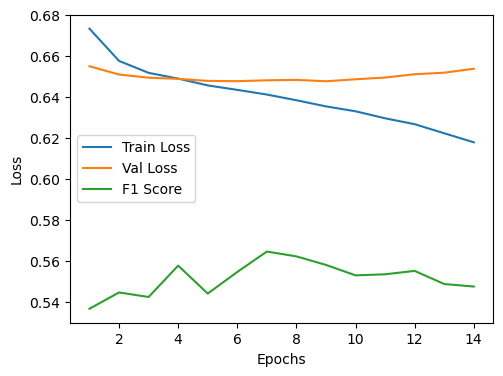




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[4507 1913]
 [2113 2991]] 

Accuracy: 65.1 

F1 Score: 59.8 

Balanced accuracy: 64.4 

AUC Score: 64.4 


----- TEST -----

Confusion matrix
 [[495 219]
 [262 291]] 

Accuracy: 62.0 

F1 Score: 54.8 

Balanced accuracy: 61.0 

AUC Score: 61.0 

_______________________________________________________________________


In [63]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_roberta.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_roberta.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_roberta, y_train, X_test_embeddings_roberta, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_roberta_train, accuracy_nn_roberta_train, f1_nn_roberta_train, balaccuracy_nn_roberta_train, rocauc_nn_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_nn_roberta_test, accuracy_nn_roberta_test, f1_nn_roberta_test, balaccuracy_nn_roberta_test, rocauc_nn_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

In [64]:
cm_nn_roberta_train_tosave = repr(cm_nn_roberta_train)
accuracy_nn_roberta_train_tosave = repr(accuracy_nn_roberta_train)
f1_nn_roberta_train_tosave = repr(f1_nn_roberta_train)
balaccuracy_nn_roberta_train_tosave = repr(balaccuracy_nn_roberta_train)
rocauc_nn_roberta_train_tosave = repr(rocauc_nn_roberta_train)

cm_nn_roberta_test_tosave = repr(cm_nn_roberta_test)
accuracy_nn_roberta_test_tosave = repr(accuracy_nn_roberta_test)
f1_nn_roberta_test_tosave = repr(f1_nn_roberta_test)
balaccuracy_nn_roberta_test_tosave = repr(balaccuracy_nn_roberta_test)
rocauc_nn_roberta_test_tosave = repr(rocauc_nn_roberta_test)


file = open("results_split/nn_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".txt", "w")

file.write("Train CM = "+cm_nn_roberta_train_tosave + "\n" +
           "Train Accuracy = " + accuracy_nn_roberta_train_tosave + "\n" +
           "Train F1 = "+f1_nn_roberta_train_tosave + "\n"+
           "Train Balanced Accuracy = "+balaccuracy_nn_roberta_train_tosave + "\n" +
           "Train ROCAUC = "+rocauc_nn_roberta_train_tosave + "\n"+
           "Test CM = "+cm_nn_roberta_test_tosave + "\n"+
           "Test Accuracy = "+accuracy_nn_roberta_test_tosave + "\n"+
           "Test F1 = "+f1_nn_roberta_test_tosave + "\n"+
           "Test Balanced Accuracy = "+balaccuracy_nn_roberta_test_tosave + "\n"+
           "Test ROCAUC = "+rocauc_nn_roberta_test_tosave)

file.close()

# Results

In [267]:
#create data
data = [["LR+GloVe", accuracy_lr_glove_test, f1_lr_glove_test, balaccuracy_lr_glove_test, rocauc_lr_glove_test],
        ["KNN+GloVe", accuracy_knn_glove_test, f1_knn_glove_test, balaccuracy_knn_glove_test, rocauc_knn_glove_test],
        ["SVC+GloVe", accuracy_svc_glove_test, f1_svc_glove_test, balaccuracy_svc_glove_test, rocauc_svc_glove_test],
        ["RandomForest+GloVe", accuracy_rf_glove_test, f1_rf_glove_test, balaccuracy_rf_glove_test, rocauc_rf_glove_test],
        ["XGBoost+GloVe", accuracy_xgb_glove_test, f1_xgb_glove_test, balaccuracy_xgb_glove_test, rocauc_xgb_glove_test],
        ["NeuralNetwork+GloVe", accuracy_nn_glove_test, f1_nn_glove_test, balaccuracy_nn_glove_test, rocauc_nn_glove_test],
        ["LR+Word2Vec", accuracy_lr_w2v_test, f1_lr_w2v_test, balaccuracy_lr_w2v_test, rocauc_lr_w2v_test],
        ["KNN+Word2Vec", accuracy_knn_w2v_test, f1_knn_w2v_test, balaccuracy_knn_w2v_test, rocauc_knn_w2v_test],
        ["SVC+Word2Vec", accuracy_svc_w2v_test, f1_svc_w2v_test, balaccuracy_svc_w2v_test, rocauc_svc_w2v_test],
        ["RandomForest+Word2Vec", accuracy_rf_w2v_test, f1_rf_w2v_test, balaccuracy_rf_w2v_test, rocauc_rf_w2v_test],
        ["XGBoost+Word2Vec", accuracy_xgb_w2v_test, f1_xgb_w2v_test, balaccuracy_xgb_w2v_test, rocauc_xgb_w2v_test],
        ["NeuralNetwork+Word2Vec", accuracy_nn_w2v_test, f1_nn_w2v_test, balaccuracy_nn_w2v_test, rocauc_nn_w2v_test],
        ["LR+BERT", accuracy_lr_bert_test, f1_lr_bert_test, balaccuracy_lr_bert_test, rocauc_lr_bert_test],
        ["KNN+BERT", accuracy_knn_bert_test, f1_knn_bert_test, balaccuracy_knn_bert_test, rocauc_knn_bert_test],
        ["SVC+BERT", accuracy_svc_bert_test, f1_svc_bert_test, balaccuracy_svc_bert_test, rocauc_svc_bert_test],
        ["RandomForest+BERT", accuracy_rf_bert_test, f1_rf_bert_test, balaccuracy_rf_bert_test, rocauc_rf_bert_test],
        ["XGBoost+BERT", accuracy_xgb_bert_test, f1_xgb_bert_test, balaccuracy_xgb_bert_test, rocauc_xgb_bert_test],
        ["NeuralNetwork+BERT", accuracy_nn_bert_test, f1_nn_bert_test, balaccuracy_nn_bert_test, rocauc_nn_bert_test],
        ["LR+RoBERTa", accuracy_lr_roberta_test, f1_lr_roberta_test, balaccuracy_lr_roberta_test, rocauc_lr_roberta_test],
        ["KNN+RoBERTa", accuracy_knn_roberta_test, f1_knn_roberta_test, balaccuracy_knn_roberta_test, rocauc_knn_roberta_test],
        ["SVC+RoBERTa", accuracy_svc_roberta_test, f1_svc_roberta_test, balaccuracy_svc_roberta_test, rocauc_svc_roberta_test],
        ["RandomForest+RoBERTa", accuracy_rf_roberta_test, f1_rf_roberta_test, balaccuracy_rf_roberta_test, rocauc_rf_roberta_test],
        ["XGBoost+RoBERTa", accuracy_xgb_roberta_test, f1_xgb_roberta_test, balaccuracy_xgb_roberta_test, rocauc_xgb_roberta_test],
        ["NeuralNetwork+RoBERTa", accuracy_nn_roberta_test, f1_nn_roberta_test, balaccuracy_nn_roberta_test, rocauc_nn_roberta_test],
        ["LR+GPT2", accuracy_lr_gpt2_test, f1_lr_gpt2_test, balaccuracy_lr_gpt2_test, rocauc_lr_gpt2_test],
        ["KNN+GPT2", accuracy_knn_gpt2_test, f1_knn_gpt2_test, balaccuracy_knn_gpt2_test, rocauc_knn_gpt2_test],
        ["SVC+GPT2", accuracy_svc_gpt2_test, f1_svc_gpt2_test, balaccuracy_svc_gpt2_test, rocauc_svc_gpt2_test],
        ["RandomForest+GPT2", accuracy_rf_gpt2_test, f1_rf_gpt2_test, balaccuracy_rf_gpt2_test, rocauc_rf_gpt2_test],
        ["XGBoost+GPT2", accuracy_xgb_gpt2_test, f1_xgb_gpt2_test, balaccuracy_xgb_gpt2_test, rocauc_xgb_gpt2_test],
        ["NeuralNetwork+GPT2", accuracy_nn_gpt2_test, f1_nn_gpt2_test, balaccuracy_nn_gpt2_test, rocauc_nn_gpt2_test]]
  
#define header names
col_names = ["Model", "Accuracy", "F1-Score", "Balanced Accuracy", "ROC AUC"]

#save results to csv
if fast:
    with open("results_fast_"+time.strftime("%Y%m%d-%H%M%S")+".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(col_names)
        for row in data:
            writer.writerow(row)
else:
    with open("results_"+time.strftime("%Y%m%d-%H%M%S")+".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(col_names)
        for row in data:
            writer.writerow(row)

#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════════╤════════════╤════════════╤═════════════════════╤═══════════╕
│ Model                   │   Accuracy │   F1-Score │   Balanced Accuracy │   ROC AUC │
╞═════════════════════════╪════════════╪════════════╪═════════════════════╪═══════════╡
│ LR+GloVe                │       64.6 │       78.5 │                50   │      50   │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ KNN+GloVe               │       60.8 │       73.8 │                50.6 │      50.6 │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ SVC+GloVe               │       64.6 │       78.5 │                50   │      50   │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ RandomForest+GloVe      │       61.7 │       75.9 │                48.8 │      48.8 │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ XGBoost+GloVe           │     

In [268]:
#print(tabulate(data, headers=col_names, tablefmt="latex"))

\begin{tabular}{lrrrr}
\hline
 Model                   &   Accuracy &   F1-Score &   Balanced Accuracy &   ROC AUC \\
\hline
 LR+GloVe                &       64.6 &       78.5 &                50   &      50   \\
 KNN+GloVe               &       60.8 &       73.8 &                50.6 &      50.6 \\
 SVC+GloVe               &       64.6 &       78.5 &                50   &      50   \\
 RandomForest+GloVe      &       61.7 &       75.9 &                48.8 &      48.8 \\
 XGBoost+GloVe           &       63.4 &       77.1 &                50.3 &      50.3 \\
 NeuralNetwork+GloVe     &       62.4 &       74.4 &                53.2 &      53.2 \\
 LR+Word2Vec             &       64.6 &       78.5 &                50   &      50   \\
 KNN+Word2Vec            &       60.7 &       73.8 &                50.4 &      50.4 \\
 SVC+Word2Vec            &       64   &       77.9 &                49.9 &      49.9 \\
 RandomForest + Word2Vec &       61.5 &       74.6 &                50.7 &      50.

In [110]:
# #create data
# lr_results = [
#     ["GloVe", accuracy_lr_glove_test, f1_lr_glove_test],
#     ["Word2Vec", accuracy_lr_w2v_test, f1_lr_w2v_test],
#     ["BERT", accuracy_lr_bert_test, f1_lr_bert_test],
#     ["RoBERTa", accuracy_lr_roberta_test, f1_lr_roberta_test],
#     ["GPT2", accuracy_lr_gpt2_test, f1_lr_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("Logistic Regression")
# # print(tabulate(lr_results, headers=col_names, tablefmt="fancy_grid"))

Logistic Regression
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53.4 │       33.2 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       59   │       40.7 │
├──────────┼────────────┼────────────┤
│ BERT     │       52.8 │       34.6 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       51.9 │       38   │
├──────────┼────────────┼────────────┤
│ GPT2     │       55.2 │       37.6 │
╘══════════╧════════════╧════════════╛


In [111]:
# #create data
# knn_results = [
#     ["GloVe", accuracy_knn_glove_test, f1_knn_glove_test],
#     ["Word2Vec", accuracy_knn_w2v_test, f1_knn_w2v_test],
#     ["BERT", accuracy_knn_bert_test, f1_knn_bert_test],
#     ["RoBERTa", accuracy_knn_roberta_test, f1_knn_roberta_test],
#     ["GPT2", accuracy_knn_gpt2_test, f1_knn_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("KNN")
# print(tabulate(knn_results, headers=col_names, tablefmt="fancy_grid"))

KNN
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53.7 │       34.7 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       55.5 │       40   │
├──────────┼────────────┼────────────┤
│ BERT     │       53.1 │       35.7 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       52.8 │       38.2 │
├──────────┼────────────┼────────────┤
│ GPT2     │       48.5 │       46.6 │
╘══════════╧════════════╧════════════╛


In [112]:
# #create data
# svc_results = [
#     ["GloVe", accuracy_svc_glove_test, f1_svc_glove_test],
#     ["Word2Vec", accuracy_svc_w2v_test, f1_svc_w2v_test],
#     ["BERT", accuracy_svc_bert_test, f1_svc_bert_test],
#     ["RoBERTa", accuracy_svc_roberta_test, f1_svc_roberta_test],
#     ["GPT2", accuracy_svc_gpt2_test, f1_svc_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("SVM Classifier")
# print(tabulate(svc_results, headers=col_names, tablefmt="fancy_grid"))

SVM Classifier
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       56.1 │       34.4 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       59.3 │       39.2 │
├──────────┼────────────┼────────────┤
│ BERT     │       50.4 │       33   │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       52.9 │       36   │
├──────────┼────────────┼────────────┤
│ GPT2     │       55.6 │       35.7 │
╘══════════╧════════════╧════════════╛


In [113]:
# #create data
# rf_results = [
#     ["GloVe", accuracy_rf_glove_test, f1_rf_glove_test],
#     ["Word2Vec", accuracy_rf_w2v_test, f1_rf_w2v_test],
#     ["BERT", accuracy_rf_bert_test, f1_rf_bert_test],
#     ["RoBERTa", accuracy_rf_roberta_test, f1_rf_roberta_test],
#     ["GPT2", accuracy_rf_gpt2_test, f1_rf_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("Random Forest")
# print(tabulate(rf_results, headers=col_names, tablefmt="fancy_grid"))

Random Forest
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       61.2 │       22.9 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       62.9 │       29.9 │
├──────────┼────────────┼────────────┤
│ BERT     │       57.9 │       22.4 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       61.4 │       19.7 │
├──────────┼────────────┼────────────┤
│ GPT2     │       58.2 │       17.2 │
╘══════════╧════════════╧════════════╛


In [114]:
# #create data
# xgb_results = [
#     ["GloVe", accuracy_xgb_glove_test, f1_xgb_glove_test],
#     ["Word2Vec", accuracy_xgb_w2v_test, f1_xgb_w2v_test],
#     ["BERT", accuracy_xgb_bert_test, f1_xgb_bert_test],
#     ["RoBERTa", accuracy_xgb_roberta_test, f1_xgb_roberta_test],
#     ["GPT2", accuracy_xgb_gpt2_test, f1_xgb_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("XGBoost")
# print(tabulate(xgb_results, headers=col_names, tablefmt="fancy_grid"))

XGBoost
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53   │       36.4 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       56.3 │       38.2 │
├──────────┼────────────┼────────────┤
│ BERT     │       52.3 │       34.8 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       53.9 │       36.2 │
├──────────┼────────────┼────────────┤
│ GPT2     │       52.6 │       35.9 │
╘══════════╧════════════╧════════════╛


In [115]:
#create data
nn_results = [
    ["GloVe", accuracy_nn_glove_test, f1_nn_glove_test],
    ["Word2Vec", accuracy_nn_w2v_test, f1_nn_w2v_test],
    ["BERT", accuracy_nn_bert_test, f1_nn_bert_test],
    ["RoBERTa", accuracy_nn_roberta_test, f1_nn_roberta_test],
    ["GPT2", accuracy_nn_gpt2_test, f1_nn_gpt2_test]
]

#define header names
col_names = ["Model", "Accuracy", "F1-Score"]

#display table
print("NeuralNetwork")
print(tabulate(nn_results, headers=col_names, tablefmt="fancy_grid"))

NeuralNetwork
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       52.5 │       37.8 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       60.1 │       40   │
├──────────┼────────────┼────────────┤
│ BERT     │       59.6 │       17.9 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       62.5 │        9.5 │
├──────────┼────────────┼────────────┤
│ GPT2     │       56.4 │       29   │
╘══════════╧════════════╧════════════╛


---